<a href="https://colab.research.google.com/github/Giovo17/cardio_disease-disease-analysis/blob/main/cardio_disease_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cardio disease analysis

In [124]:
# colab related
!pip install matplotlib --upgrade
!pip install sklearn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [125]:
# Importing main libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay


plt.rcParams.update({'figure.figsize': (10.0, 10.0)})
plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({'figure.dpi': 300})

In [126]:
data_source = "https://raw.githubusercontent.com/Giovo17/cardio-disease-analysis/main/cardio_train.csv"
df = pd.read_csv(data_source, sep=";", index_col="id")
df = df.rename(columns={"ap_hi": "systolic_bp", "ap_lo": "diastolic_bp",
                        "gluc": "glucose", "alco": "alcool_intake",
                        "active": "physical_activity", "cardio": "cardio_disease"})

In [127]:
df.head()

age  gender  height  weight  systolic_bp  diastolic_bp  cholesterol  \
id                                                                          
0   18393       2     168    62.0          110            80            1   
1   20228       1     156    85.0          140            90            3   
2   18857       1     165    64.0          130            70            3   
3   17623       2     169    82.0          150           100            1   
4   17474       1     156    56.0          100            60            1   

    glucose  smoke  alcool_intake  physical_activity  cardio_disease  
id                                                                    
0         1      0              0                  1               0  
1         1      0              0                  1               1  
2         1      0              0                  0               1  
3         1      0              0                  1               1  
4         1      0              0                  0               0

#### Data description reported by authors

There are 3 types of input features:

1. Objective: factual information;
2. Examination: results of medical examination;
3. Subjective: information given by the patient.


| Feature | Feature type | Name in dataset | Data type
| :---: | :-------------------: | :-----: | :-----------: |
|Age | Objective Feature | age | int (days)|
|Gender | Objective Feature | gender | categorical code (1: female, 2: male) |
|Height | Objective Feature | height | int (cm) |
|Weight | Objective Feature | weight | float (kg) |
|Systolic blood pressure | Examination Feature | systolic_bp | int |
|Diastolic blood pressure | Examination Feature | diastolic_bp | int |
|Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
|Glucose | Examination Feature | glucose | 1: normal, 2: above normal, 3: well above normal |
|Smoking | Subjective Feature | smoke | binary |
|Alcohol intake | Subjective Feature | alcool | binary |
|Physical activity | Subjective Feature | physical_activity | binary |
|Presence or absence of cardiovascular disease | Target Variable | cardio_disease | binary |

All of the dataset values were collected at the moment of medical examination. 

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                70000 non-null  int64  
 1   gender             70000 non-null  int64  
 2   height             70000 non-null  int64  
 3   weight             70000 non-null  float64
 4   systolic_bp        70000 non-null  int64  
 5   diastolic_bp       70000 non-null  int64  
 6   cholesterol        70000 non-null  int64  
 7   glucose            70000 non-null  int64  
 8   smoke              70000 non-null  int64  
 9   alcool_intake      70000 non-null  int64  
 10  physical_activity  70000 non-null  int64  
 11  cardio_disease     70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


There are no missing values

In [129]:
df["gender"] = df["gender"].map({1: 0, 2: 1})

Add the BMI feature from height and weight

In [130]:
BMI = df["weight"] / (df["height"] / 100)**2
df.insert (4, "BMI", BMI)

Convert age in years

In [131]:
df["age"] = (df["age"]/365).astype(int)

In [132]:
df.head()

age  gender  height  weight        BMI  systolic_bp  diastolic_bp  \
id                                                                      
0    50       1     168    62.0  21.967120          110            80   
1    55       0     156    85.0  34.927679          140            90   
2    51       0     165    64.0  23.507805          130            70   
3    48       1     169    82.0  28.710479          150           100   
4    47       0     156    56.0  23.011177          100            60   

    cholesterol  glucose  smoke  alcool_intake  physical_activity  \
id                                                                  
0             1        1      0              0                  1   
1             3        1      0              0                  1   
2             3        1      0              0                  0   
3             1        1      0              0                  1   
4             1        1      0              0                  0   

    cardio_disease  
id                  
0                0  
1                1  
2                1  
3                1  
4                0

Search for duplicated rows

In [133]:
print("Duplicate rows: {}".format(df.duplicated().sum()))
df = df.drop_duplicates()

Duplicate rows: 3208


In [134]:
df.shape

(66792, 13)

There are no missing values.

## Data exploration and cleaning

In [135]:
def map_values(dataframe, to_numeric=False):
    if to_numeric:
        dataframe["gender"] = dataframe["gender"].map({"female": 0, "male": 1})
        dataframe["cholesterol"] = dataframe["cholesterol"].map({"normal": 1, "above normal": 2, "well above normal": 3})
        dataframe["glucose"] = dataframe["glucose"].map({"normal": 1, "above normal": 2, "well above normal": 3})
        dataframe["smoke"] = dataframe["smoke"].map({"no": 0, "yes": 1})
        dataframe["alcool_intake"] = dataframe["alcool_intake"].map({"no": 0, "yes": 1})
        dataframe["physical_activity"] = dataframe["physical_activity"].map({"inactive": 0, "active": 1})
        dataframe["cardio_disease"] = dataframe["cardio_disease"].map({"healthy": 0, "sick": 1})

    else:
        dataframe["gender"] = dataframe["gender"].map({0: "female", 1: "male"})
        dataframe["cholesterol"] = dataframe["cholesterol"].map({1: "normal", 2: "above normal", 3: "well above normal"})
        dataframe["glucose"] = dataframe["glucose"].map({1: "normal", 2: "above normal", 3: "well above normal"})
        dataframe["smoke"] = dataframe["smoke"].map({0: "no", 1: "yes"})
        dataframe["alcool_intake"] = dataframe["alcool_intake"].map({0: "no", 1: "yes"})
        dataframe["physical_activity"] = dataframe["physical_activity"].map({0: "inactive", 1: "active"})
        dataframe["cardio_disease"] = dataframe["cardio_disease"].map({0: "healthy", 1: "sick"})


    return dataframe


In [136]:
df = map_values(df, to_numeric=False)

### Categorical data

In [137]:
def get_percentages(ax_container):
    perc = []
    sum = 0
    for k in ax_container:
        sum += k.get_height()
    
    for k in ax_container:
        lab = str(k.get_height()) + "  (" + str(round(k.get_height() / sum * 100, 1)) + " %)"
        perc.append(lab)

    return perc

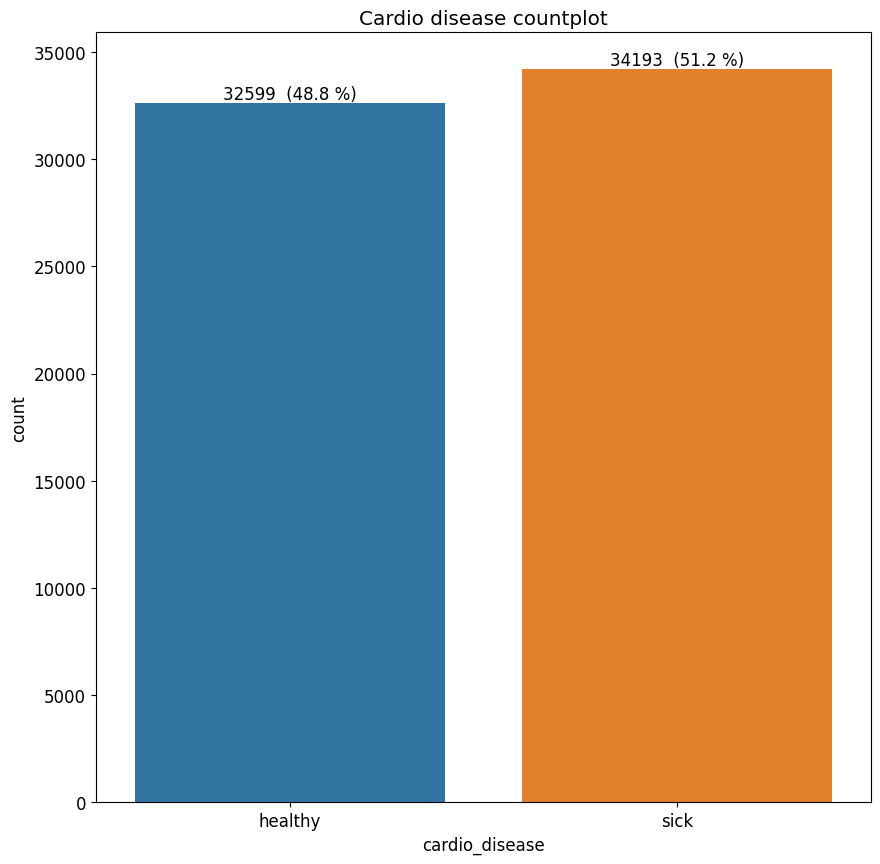

In [138]:
ax = sns.countplot(data=df, x="cardio_disease")
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.set_title("Cardio disease countplot")

plt.show()

The target variable cardio_disease is balanced

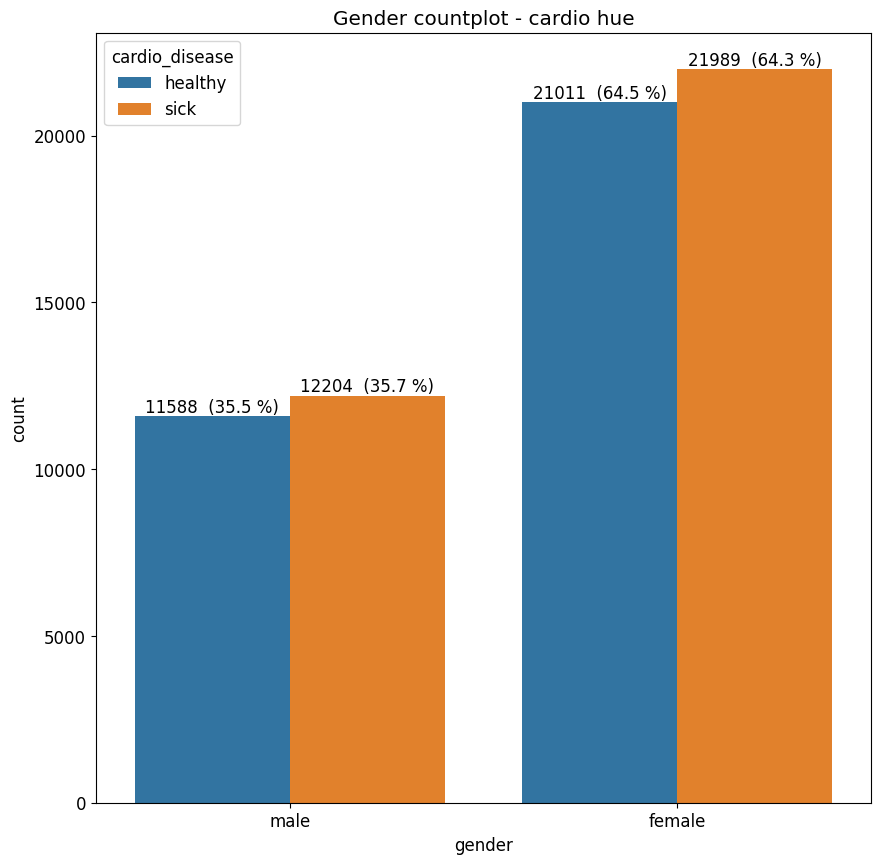

In [139]:
ax = sns.countplot(data=df, x="gender", hue="cardio_disease")
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Gender countplot - cardio hue")
plt.show()

The gender of the patient doesn't seem to have a noticeable correlation with the target variable

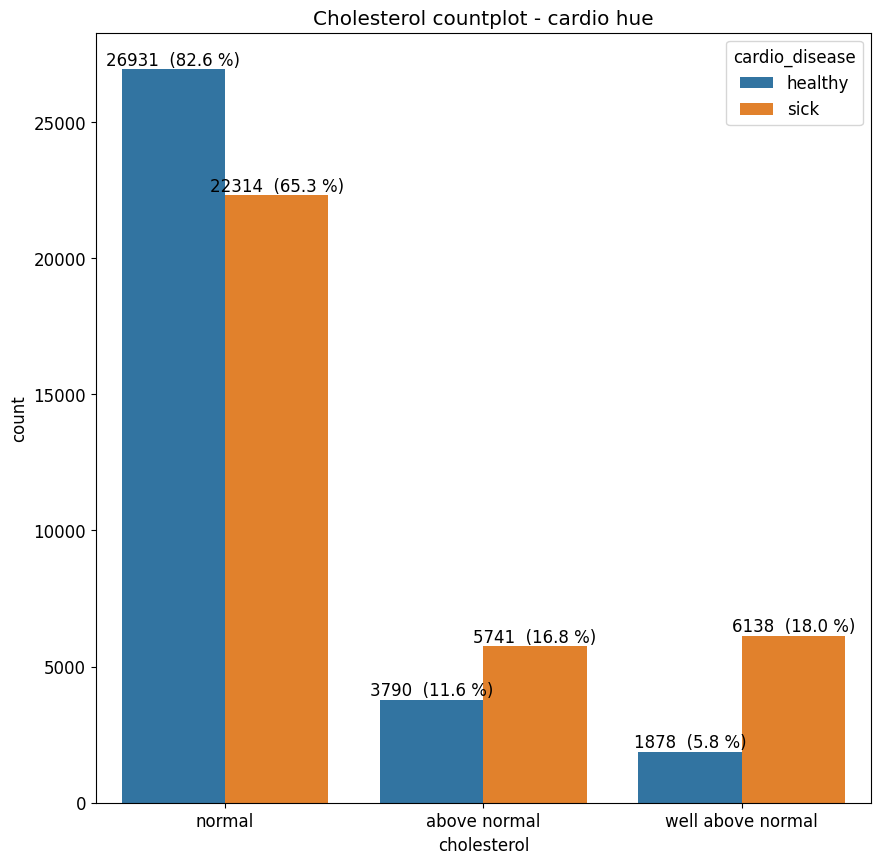

In [140]:
ax = sns.countplot(data=df, x="cholesterol", hue="cardio_disease", order=["normal", "above normal", "well above normal"])
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Cholesterol countplot - cardio hue")
plt.show()

As it can be seen on the graph the cholesterol has an impact on the target variable. 

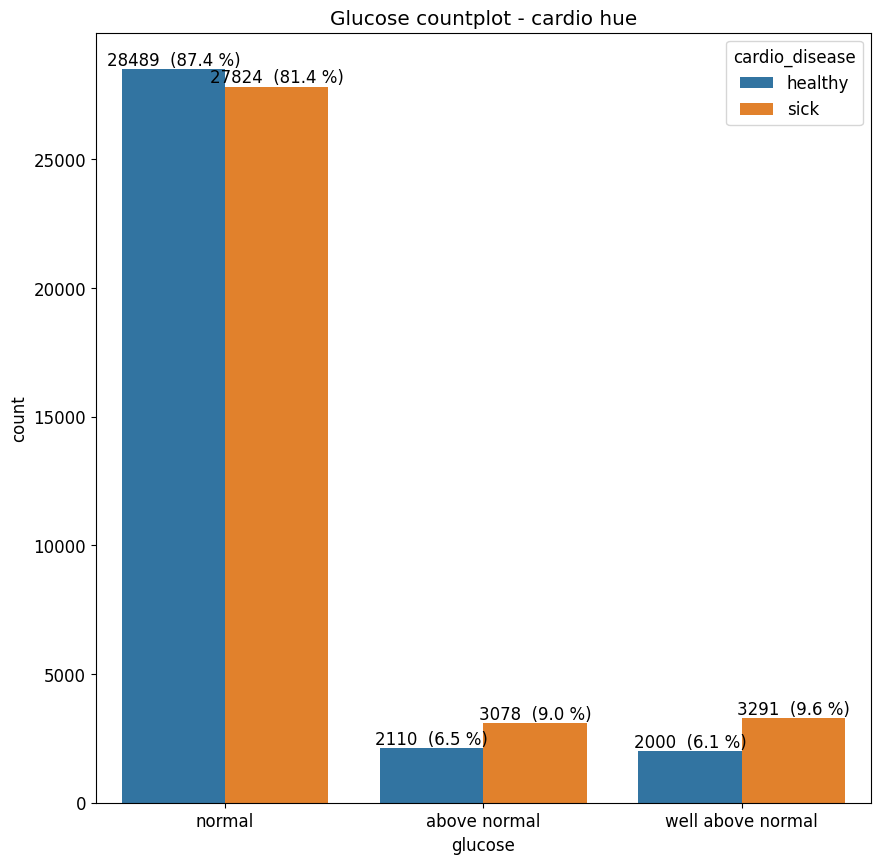

In [141]:
ax = sns.countplot(data=df, x="glucose", hue="cardio_disease", order=["normal", "above normal", "well above normal"])
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Glucose countplot - cardio hue")
plt.show()

The trend for the glucose variable is the same of the cholesterol one, but the differences between healthy and sick patients are more subtle.

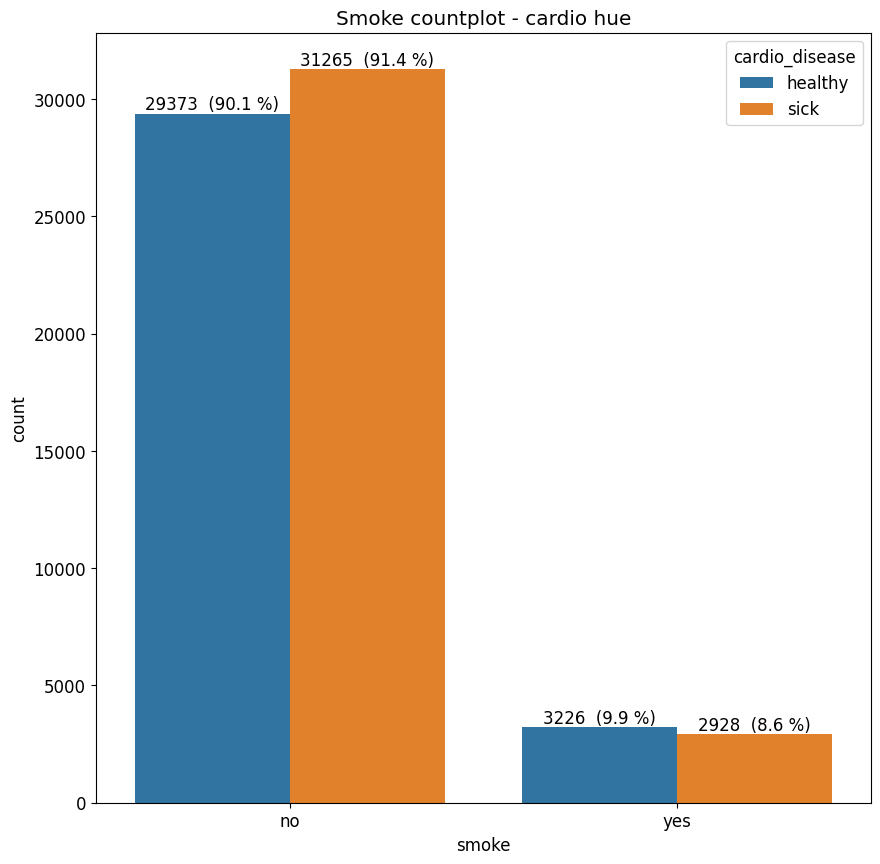

In [142]:
ax = sns.countplot(data=df, x="smoke", hue="cardio_disease")
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Smoke countplot - cardio hue")
plt.show()

The smoke feature looks like it's uncorrelated with the health of the patient

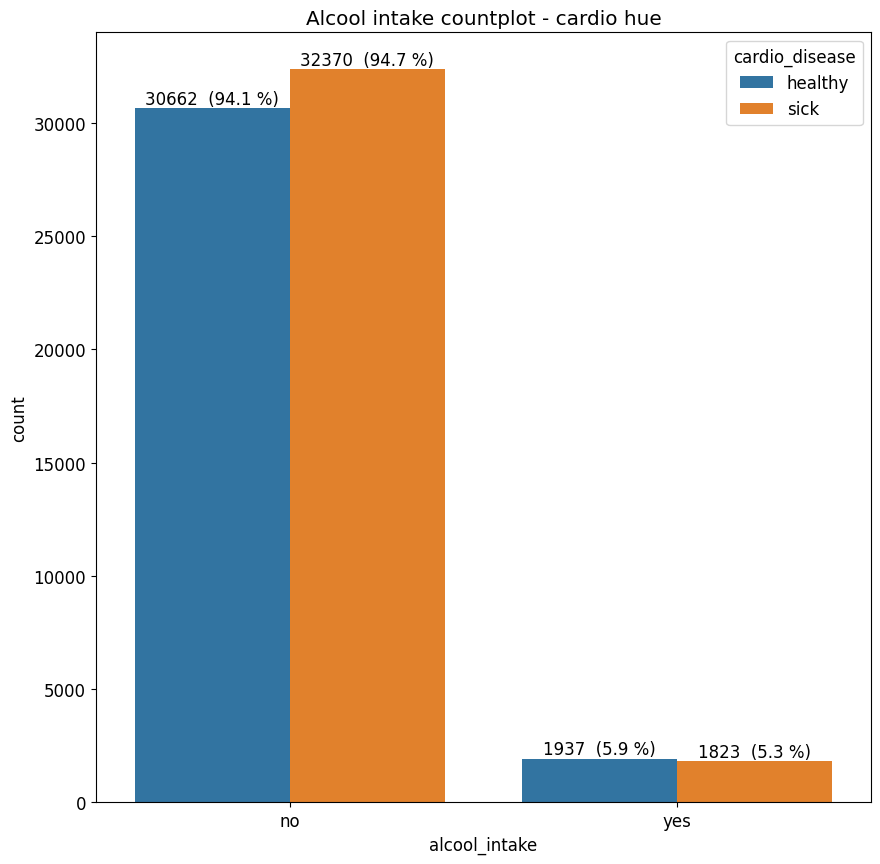

In [143]:
ax = sns.countplot(data=df, x="alcool_intake", hue="cardio_disease")
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Alcool intake countplot - cardio hue")
plt.show()

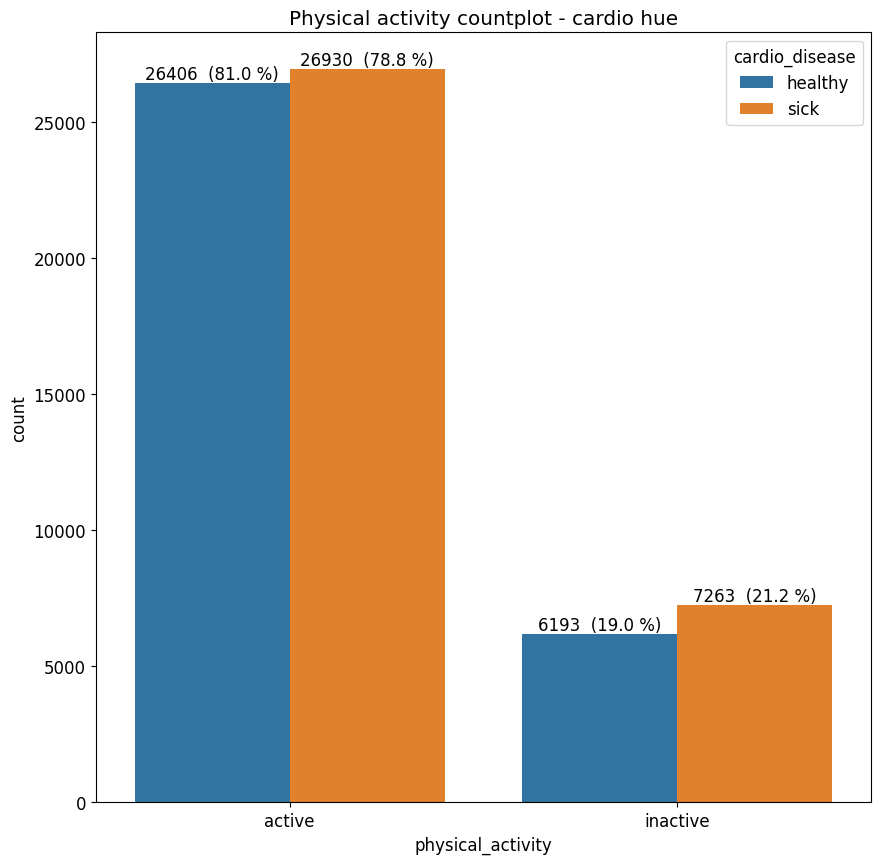

In [144]:
ax = sns.countplot(data=df, x="physical_activity", hue="cardio_disease")
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Physical activity countplot - cardio hue")
plt.show()

Alcool intake and physical activity follow the same path of the smoke feature

### Numerical data

**Age**

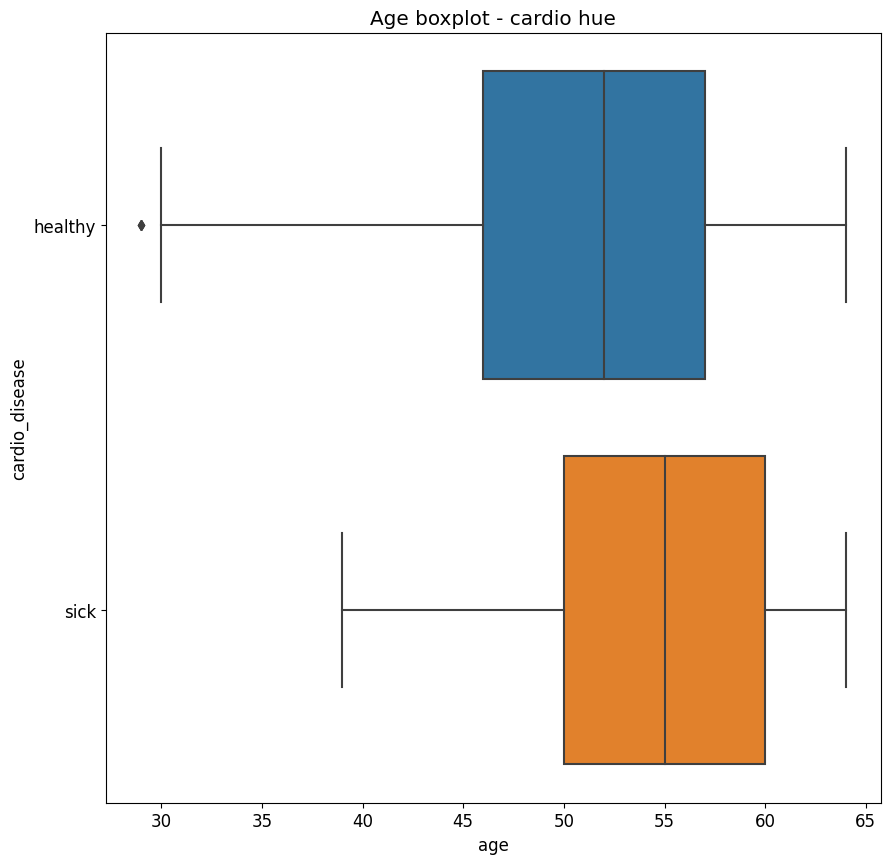

count       mean       std   min   25%   50%   75%   max
cardio_disease                                                            
healthy         32599.0  51.220191  6.847514  29.0  46.0  52.0  57.0  64.0
sick            34193.0  54.422835  6.380788  39.0  50.0  55.0  60.0  64.0

In [145]:
ax = sns.boxplot(data=df, x="age", y="cardio_disease", orient="h")
ax.set_title("Age boxplot - cardio hue")
plt.show()

df.groupby("cardio_disease")["age"].describe()

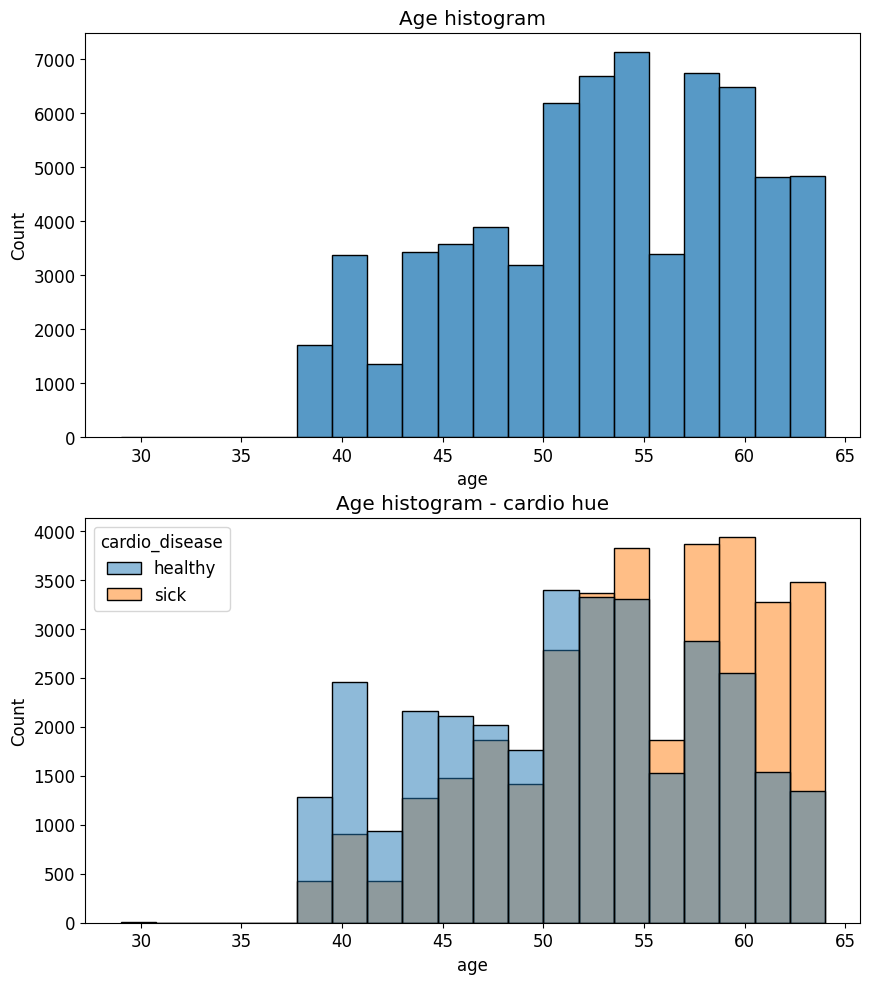

In [146]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="age", bins=20)
ax.set_title("Age histogram")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="age", bins=20, hue="cardio_disease")
ax.set_title("Age histogram - cardio hue")

plt.subplots_adjust(top=1)
plt.show()

The patients age ranges from 29 to 64, so there are only adults.

The distribution seems to be bimodal with modes around 55 and 58.

Taking into consideration the conditional boxplot this feature is slightly related to the target variable, in fact the "cardio_disease affected" patients box is has higher minimum, 1° quartile, median and 3° quartile with respect to healthy patients. Observing the conditional histplot this trend is confirmed: there's an higher concentration of unhealthy patients as the age increases. Though in both there's a considerable overlap between the two classes.

**Height, weight and BMI**

The BMI is the Body Mass Index and it's defined as $ BMI = \frac{w}{h^2} $ where $w$ is the weight in *kilograms* and $h$ is the height in *meters*

A reference table from [Ministero della salute](https://www.salute.gov.it/portale/nutrizione/dettaglioIMCNutrizione.jsp?lingua=italianoid=5479area=nut):

|Condition|BMI|
|---------|:-:|
| Severe thinness | BMI < 16 |
| Underweight | 16 < BMI < 18.49 |
| Normal weight | 18.5 < BMI < 24.99 |
| Overweight | 25 < BMI < 29.99 |
| Obese class 1 | 30 < BMI < 34.99 |
| Obese class 2 | 35 < BMI < 39.99 |
| Obese class 3 | BMI > 40 |

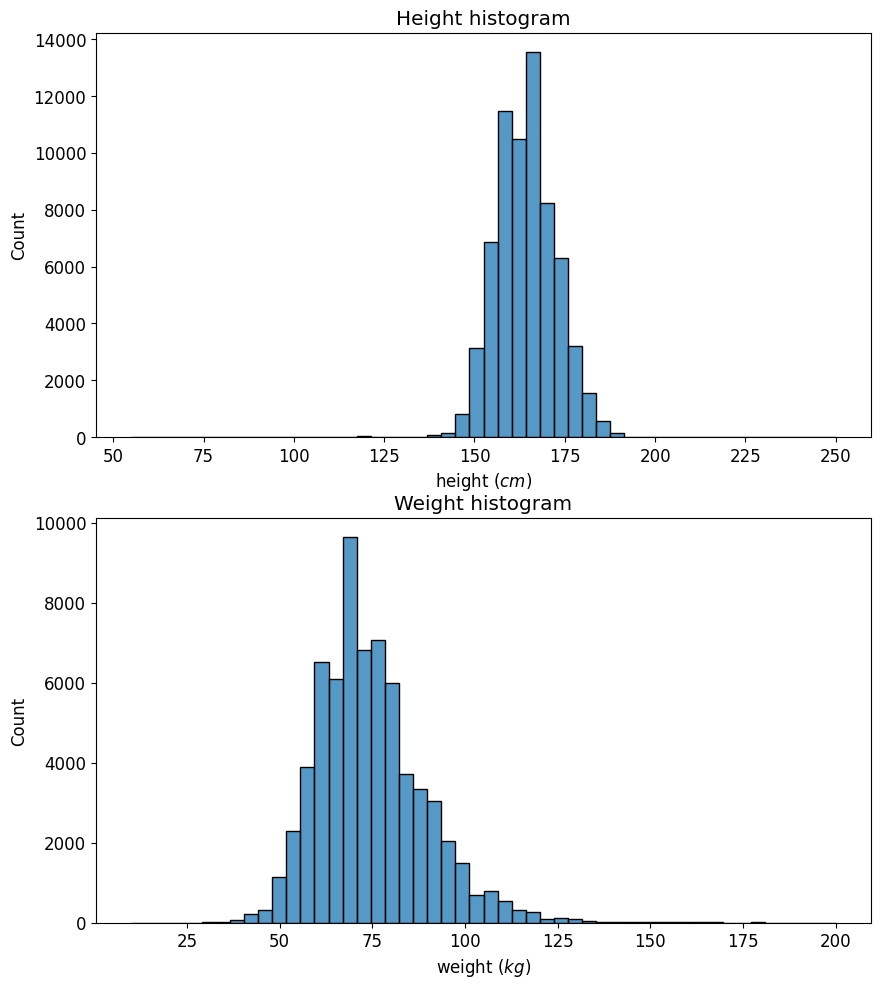

In [147]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="height", bins=50)
ax.set_xlabel("height ($cm$)")
ax.set_title("Height histogram")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="weight", bins=50)
ax.set_xlabel("weight ($kg$)")
ax.set_title("Weight histogram")

plt.subplots_adjust(top=1)
plt.show()

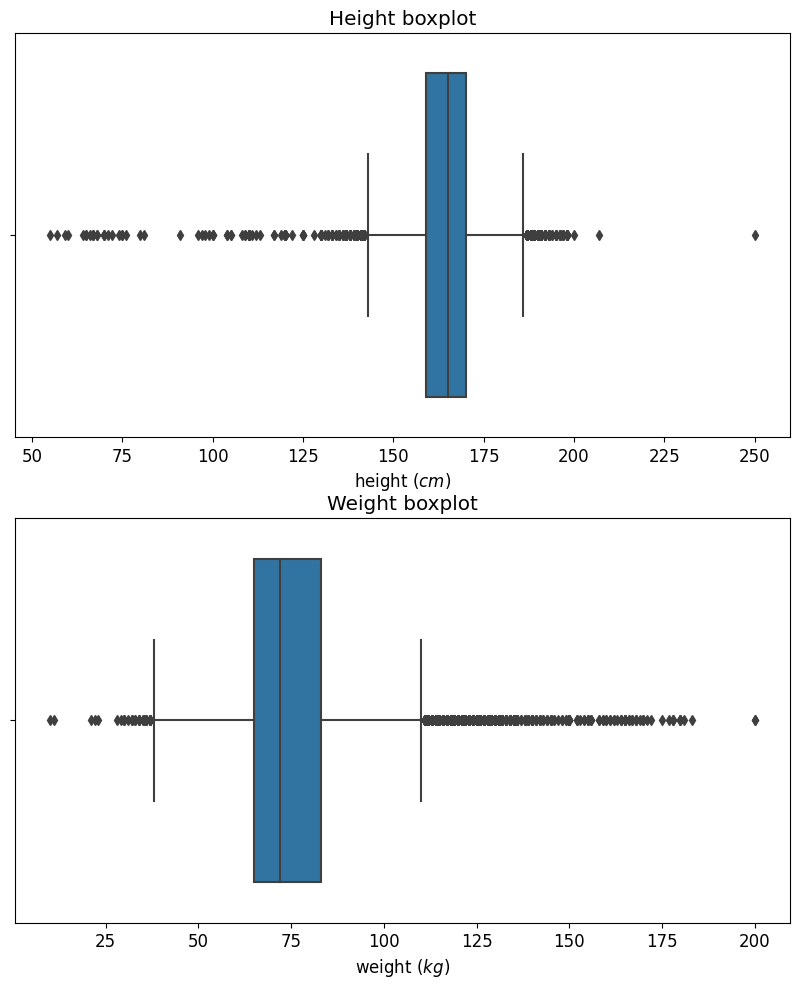

In [148]:
plt.subplot(2, 1, 1)
ax = sns.boxplot(data=df, x="height")
ax.set_xlabel("height ($cm$)")
ax.set_title("Height boxplot")

plt.subplot(2, 1, 2)
ax = sns.boxplot(data=df, x="weight")
ax.set_xlabel("weight ($kg$)")
ax.set_title("Weight boxplot")

plt.subplots_adjust(top=1)
plt.show()

In [149]:
pd.DataFrame(df["height"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

count        mean       std   min     1%    25%    50%    75%  \
height  66792.0  164.341748  8.333904  55.0  146.0  159.0  165.0  170.0   

        99.9%    max  
height  190.0  250.0

In [150]:
pd.DataFrame(df["weight"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

count      mean        std   min    1%   25%   50%   75%  99.9%  \
weight  66792.0  74.52116  14.580675  10.0  48.0  65.0  72.0  83.0  150.0   

          max  
weight  200.0

Both height and weight are unimodal distributions with modes around 165 (cm) and 65 (kg) respectively.

The height distribution looks like it isn't skewed. The weight distribution seems to be slightly positive skewed as it's right tail it's a bit longer than the left one.

These features present outliers as it can be seen from the boxplot and the correspondig statistics table.

Checking weight skeweness:

In [151]:
print("Mode: {}, median: {}, mean: {}".format(stats.mode(df["weight"], keepdims=True)[0][0], np.median(df["weight"]), round(np.mean(df["weight"]), 2)))
print("Fisher-Pearson coefficient of skewness: {}".format(round(stats.skew(df["weight"]), 2)))


Mode: 70.0, median: 72.0, mean: 74.52
Fisher-Pearson coefficient of skewness: 0.97


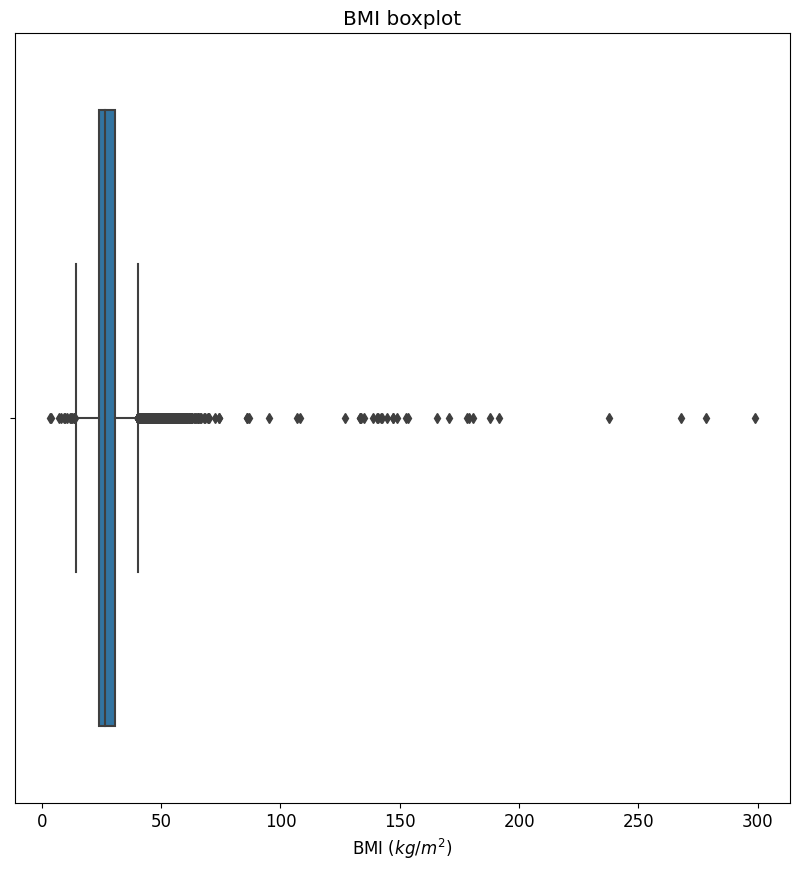

count       mean       std       min        25%        50%       75%  \
BMI  66792.0  27.682565  6.184422  3.471784  23.875115  26.573129  30.46875   

         99.9%         max  
BMI  59.623333  298.666667

In [152]:
ax = sns.boxplot(data=df, x="BMI")
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_title("BMI boxplot")
plt.show()

pd.DataFrame(df["BMI"].describe(percentiles=[0.25, 0.5, 0.75, 0.999])).T

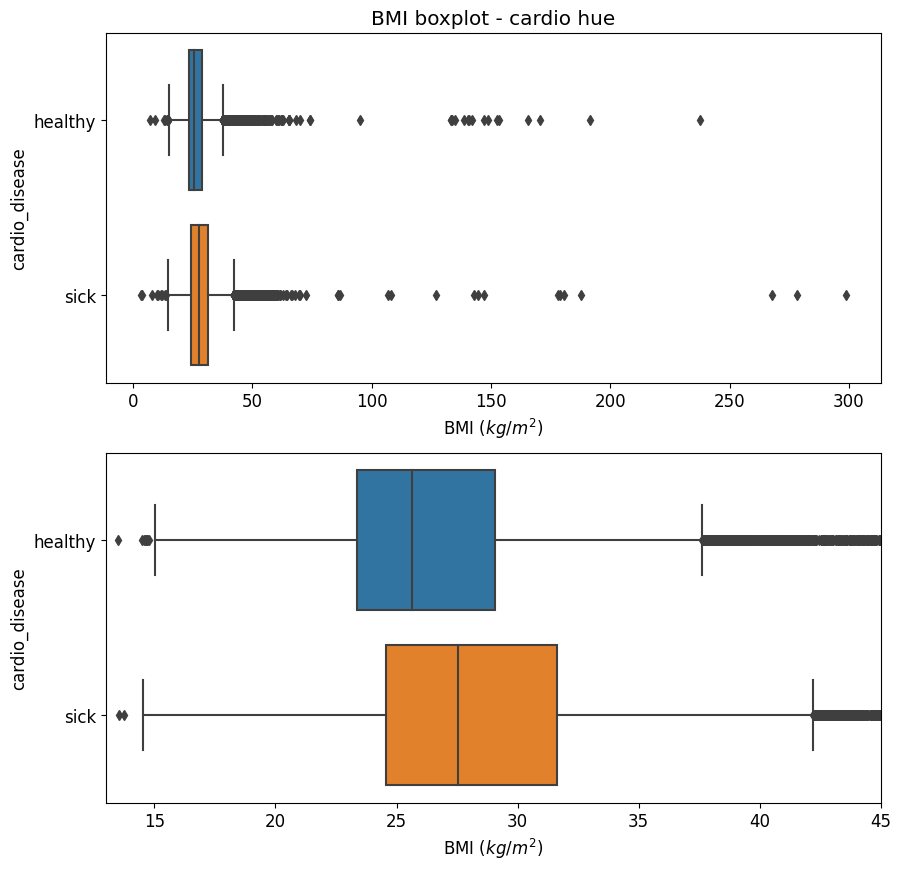

count       mean       std       min        25%        50%  \
cardio_disease                                                                 
healthy         32599.0  26.674952  5.755386  7.022248  23.372576  25.636917   
sick            34193.0  28.643205  6.421927  3.471784  24.560326  27.548209   

                      75%      99.9%         max  
cardio_disease                                    
healthy         29.060607  60.089236  237.768633  
sick            31.615793  59.458581  298.666667

In [153]:
plt.subplot(2, 1, 1)
ax = sns.boxplot(data=df, x="BMI", y="cardio_disease", orient="h")
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_title("BMI boxplot - cardio hue")

plt.subplot(2, 1, 2)
ax = sns.boxplot(data=df, x="BMI", y="cardio_disease", orient="h")
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_xlim(13, 45)

plt.show()

df.groupby("cardio_disease")["BMI"].describe(percentiles=[0.25, 0.5, 0.75, 0.999])

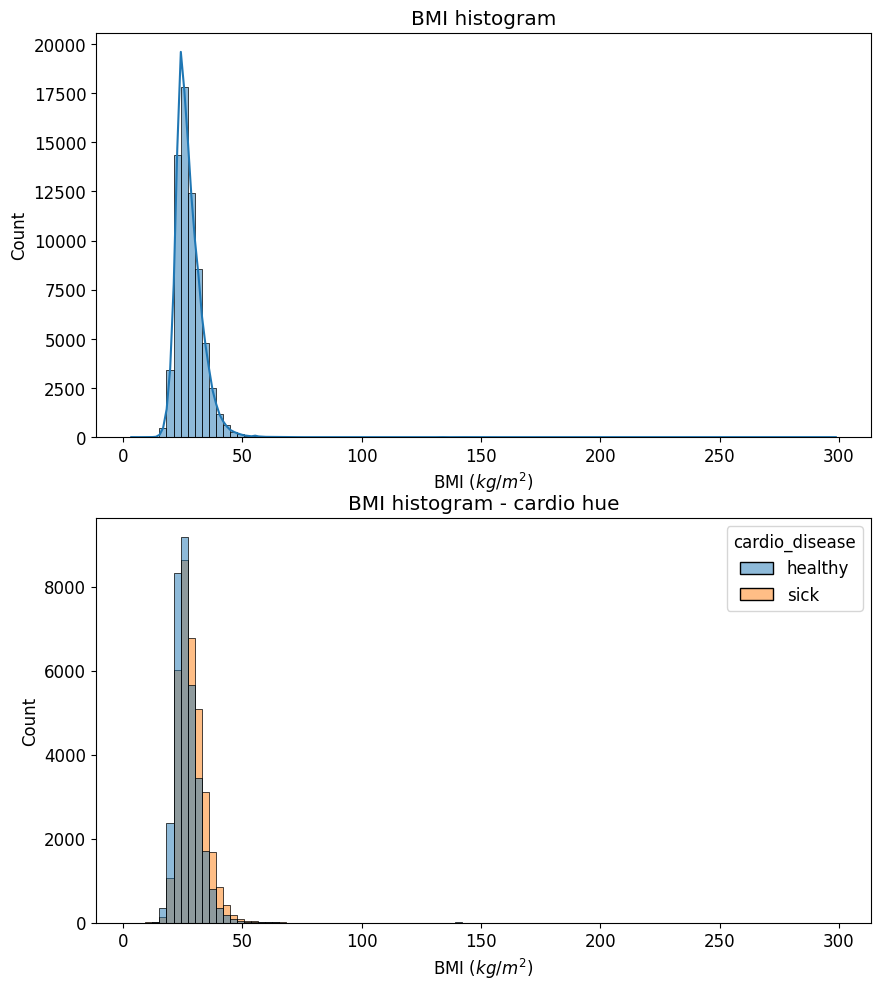

In [154]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="BMI", bins=100, kde=True)
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_title("BMI histogram")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="BMI", bins=100, hue="cardio_disease")
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_title("BMI histogram - cardio hue")

plt.subplots_adjust(top=1)
plt.show()

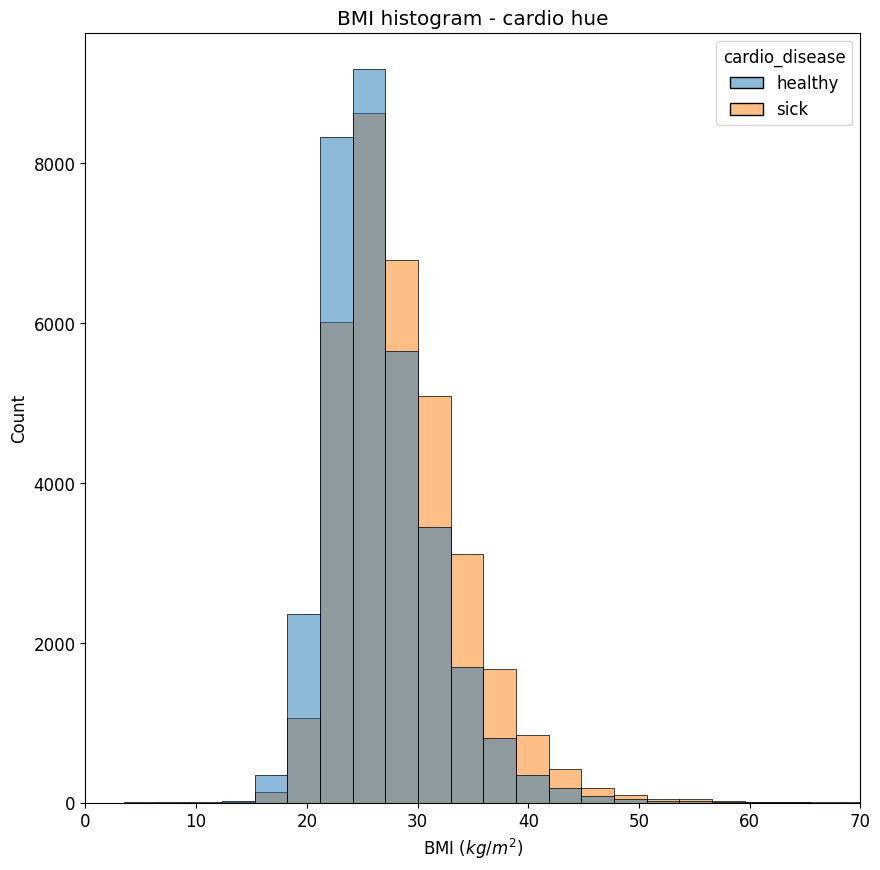

In [155]:
ax = sns.histplot(data=df, x="BMI", bins=100, hue="cardio_disease")
ax.set_xlim(0, 70)
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_title("BMI histogram - cardio hue")

plt.show()

In [156]:
print("Mode: {}, median: {}, mean: {}".format(round(stats.mode(df["BMI"], keepdims=True)[0][0], 2), round(np.median(df["BMI"]), 2), round(np.mean(df["BMI"]), 2)))
print("Fisher-Pearson coefficient of skewness: {}".format(round(stats.skew(df["BMI"]), 2)))

Mode: 23.88, median: 26.57, mean: 27.68
Fisher-Pearson coefficient of skewness: 7.69


The BMI feature is unimodal (mode in 23.88) and positively skewed as shown by the Fisher-Pearson coefficient.

There are a lot of outliers in this features.

**Systolic blood pressure and diastolic blood pressure**

These features measures the pressure in arteries respectively when the heart beats and in a period between two heatbeats.

A reference table from [heart.org](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings):

|Blood pressure category|Systolic blood pressure (mm Hg)|and/or|Diastolic blood pressure (mm Hg)|
|-----------------------|:-----------------------------:|:------:|:------------------------------:|
|Normal| systolic_bp < 120 | and| diastolic_bp < 80 |
|Elevated| 120 < systolic_bp < 129 | and | diastolic_bp < 80 |
|High blood pressure (Hypertension stage 1)| 130 < systolic_bp < 139 | or | 80 < diastolic_bp < 89 |
|High blood pressure (Hypertension stage 2)| systolic_bp > 140 | or | diastolic_bp > 90
|Hypertensive crisis| systolic_bp > 180 | and/or | diastolic_bp > 120 |


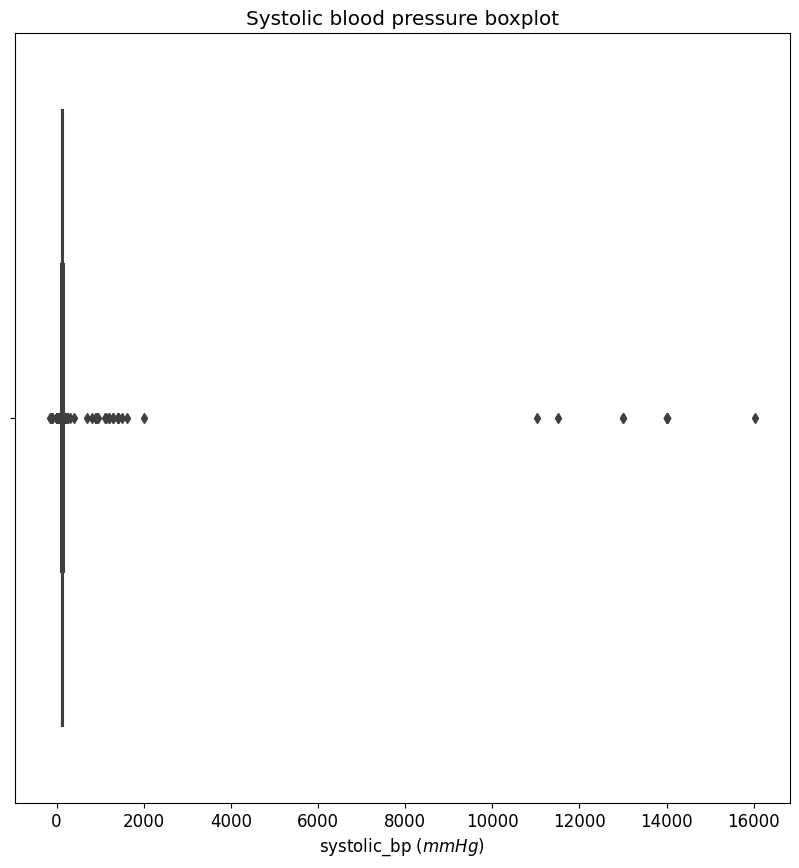

count        mean         std    min    1%    25%    50%  \
systolic_bp  66792.0  129.231585  157.649354 -150.0  90.0  120.0  120.0   

               75%  99.9%      max  
systolic_bp  140.0  220.0  16020.0

In [157]:
ax = sns.boxplot(data=df, x="systolic_bp")
ax.set_xlabel("systolic_bp ($mm Hg$)")
ax.set_title("Systolic blood pressure boxplot")
plt.show()

pd.DataFrame(df["systolic_bp"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

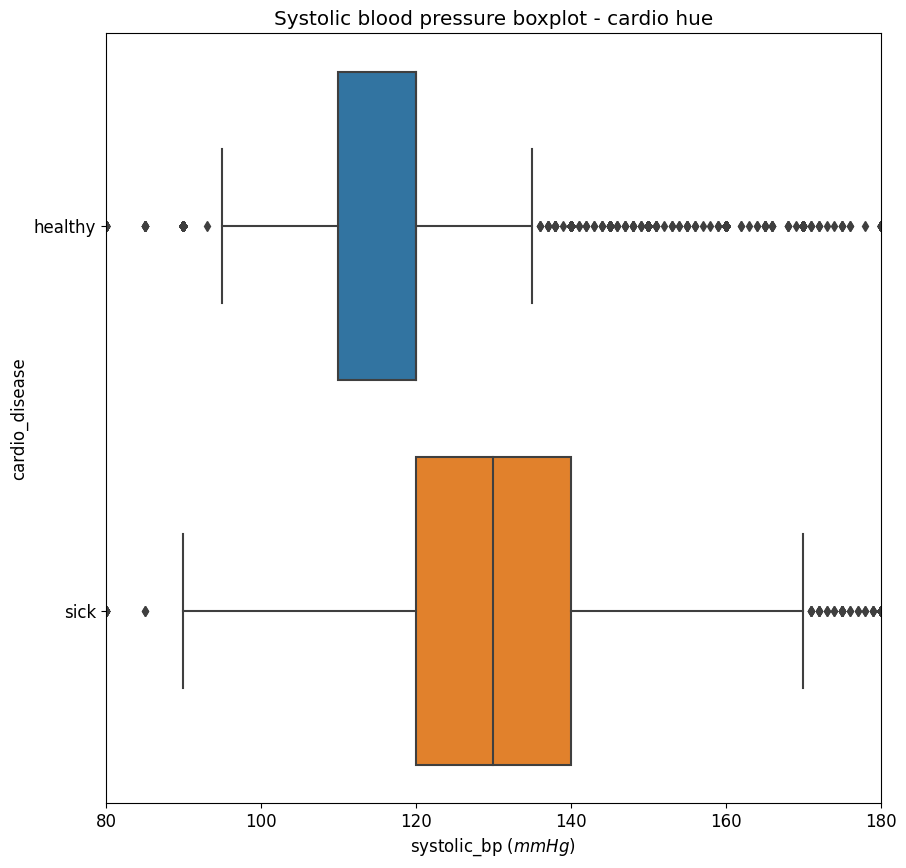

count        mean         std    min     1%    25%    50%  \
cardio_disease                                                                
healthy         32599.0  120.528728  107.320611 -120.0   90.0  110.0  120.0   
sick            34193.0  137.528734  193.460336 -150.0  100.0  120.0  130.0   

                  75%    99%      max  
cardio_disease                         
healthy         120.0  160.0  14020.0  
sick            140.0  180.0  16020.0

In [158]:
ax = sns.boxplot(data=df, x="systolic_bp", y="cardio_disease", orient="h")
ax.set_xlim(80, 180)
ax.set_xlabel("systolic_bp ($mm Hg$)")
ax.set_title("Systolic blood pressure boxplot - cardio hue")

plt.show()

df.groupby("cardio_disease")["systolic_bp"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

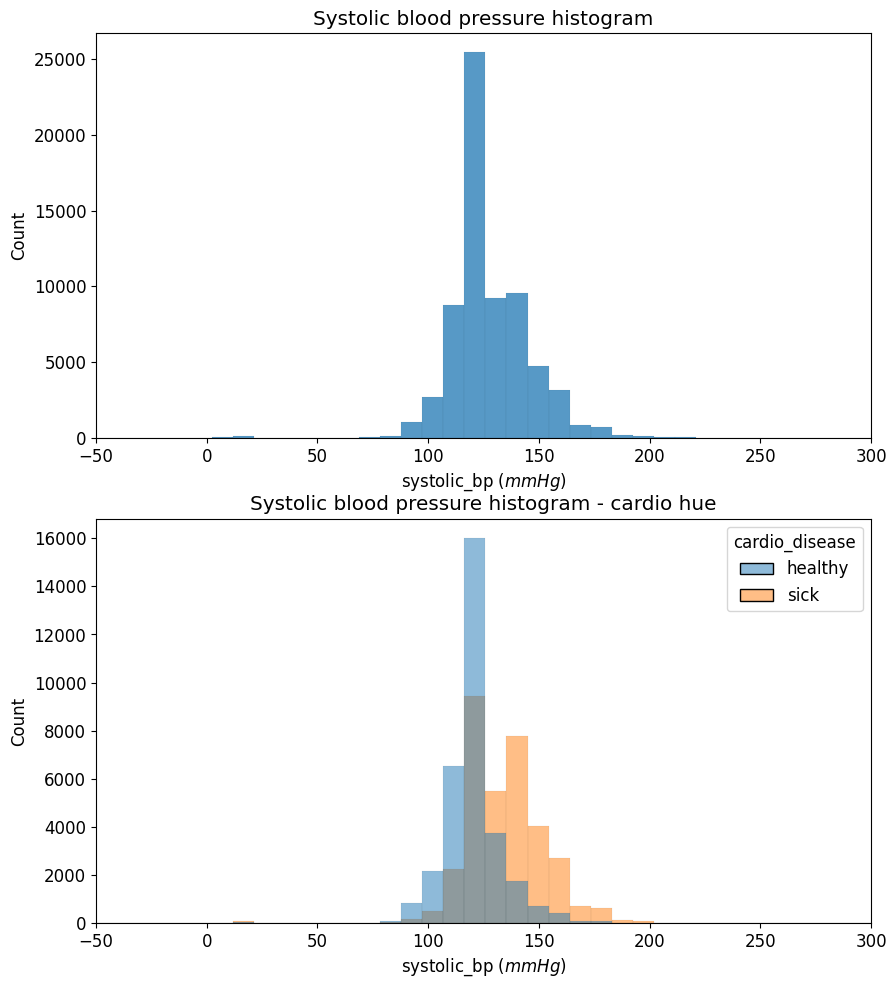

In [159]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="systolic_bp", bins=1700)
ax.set_xlim(-50, 300)
ax.set_xlabel("systolic_bp ($mm Hg$)")
ax.set_title("Systolic blood pressure histogram")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="systolic_bp", bins=1700, hue="cardio_disease")
ax.set_xlim(-50, 300)
ax.set_xlabel("systolic_bp ($mm Hg$)")
ax.set_title("Systolic blood pressure histogram - cardio hue")

plt.subplots_adjust(top=1)
plt.show()

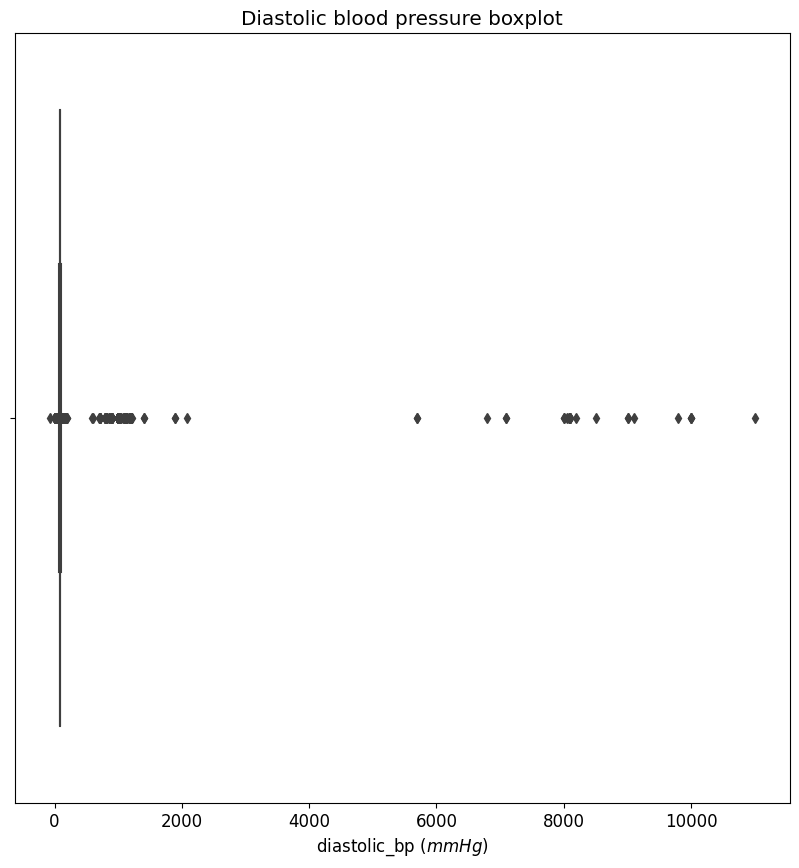

count       mean         std   min    1%   25%   50%   75%  \
diastolic_bp  66792.0  97.446221  192.906434 -70.0  60.0  80.0  80.0  90.0   

               99.9%      max  
diastolic_bp  1110.0  11000.0

In [160]:
ax = sns.boxplot(data=df, x="diastolic_bp")
ax.set_xlabel("diastolic_bp ($mm Hg$)")
ax.set_title("Diastolic blood pressure boxplot")

plt.show()

pd.DataFrame(df["diastolic_bp"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

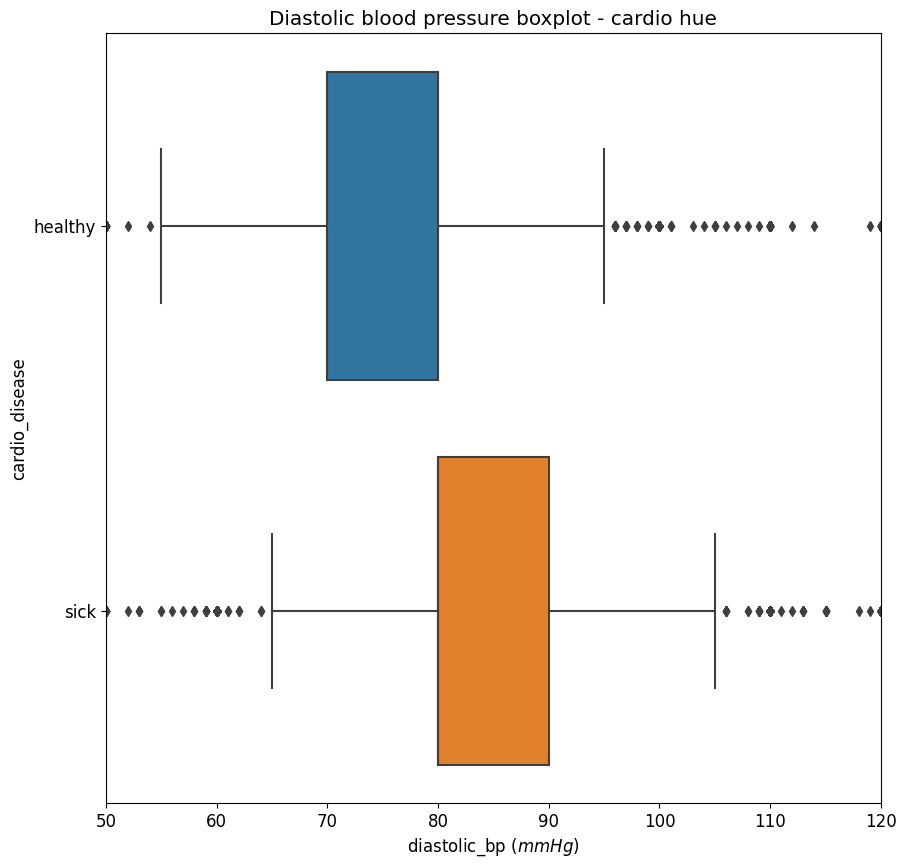

count        mean         std   min    1%   25%   50%   75%  \
cardio_disease                                                                  
healthy         32599.0   84.634743  158.248448   0.0  60.0  70.0  80.0  80.0   
sick            34193.0  109.660457  220.252704 -70.0  60.0  80.0  80.0  90.0   

                   99%      max  
cardio_disease                   
healthy          100.0   9800.0  
sick            1000.0  11000.0

In [161]:
ax = sns.boxplot(data=df, x="diastolic_bp", y="cardio_disease", orient="h")
ax.set_xlim(50, 120)
ax.set_xlabel("diastolic_bp ($mm Hg$)")
ax.set_title("Diastolic blood pressure boxplot - cardio hue")

plt.show()

df.groupby("cardio_disease")["diastolic_bp"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

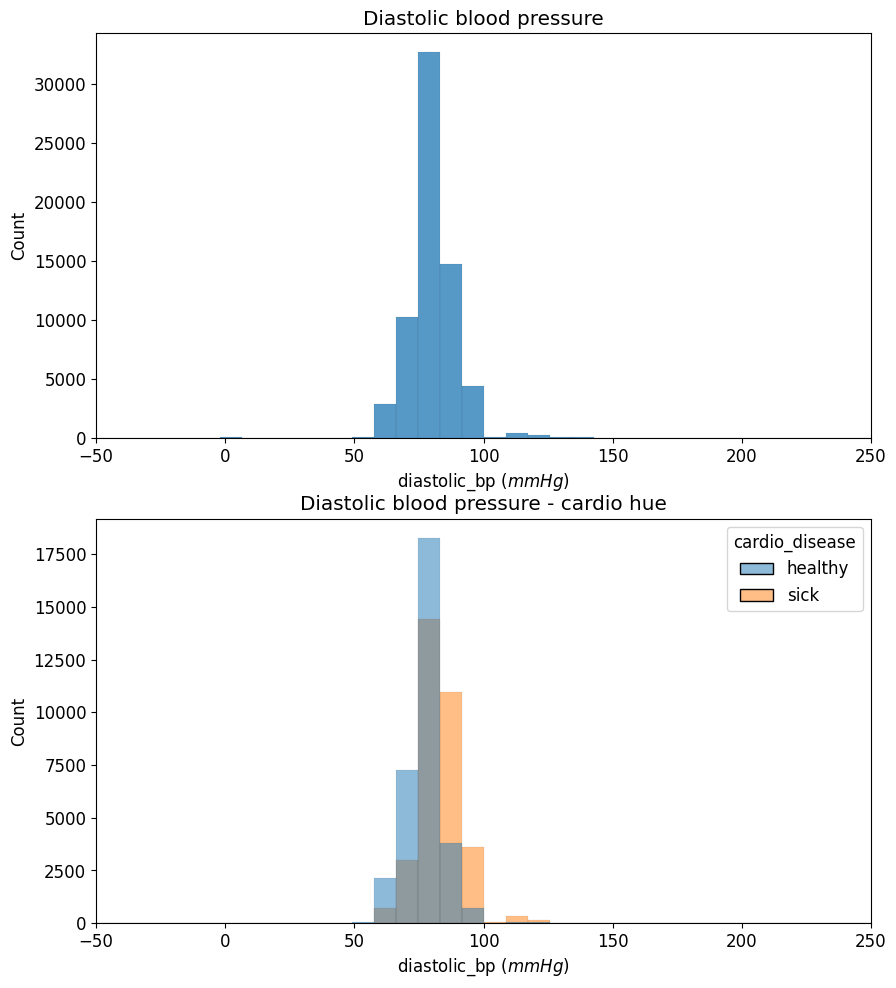

In [162]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="diastolic_bp", bins=1300)
ax.set_xlim(-50, 250)
ax.set_xlabel("diastolic_bp ($mm Hg$)")
ax.set_title("Diastolic blood pressure")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="diastolic_bp", bins=1300, hue="cardio_disease")
ax.set_xlim(-50, 250)
ax.set_xlabel("diastolic_bp ($mm Hg$)")
ax.set_title("Diastolic blood pressure - cardio hue")

plt.subplots_adjust(top=1)
plt.show()

These features have a similar behaviour. Both of them present outliers as it can be seen from the boxplots.

When not considering outliers, they are unimodal (mode around 120 mmHg and 80 mmHg respectively) and approximatevely simmetric. They are related to the cardio_disease feature as it can be seen from the boxplot and the histogram, though there's overlap between healthy and unhealthy patients.

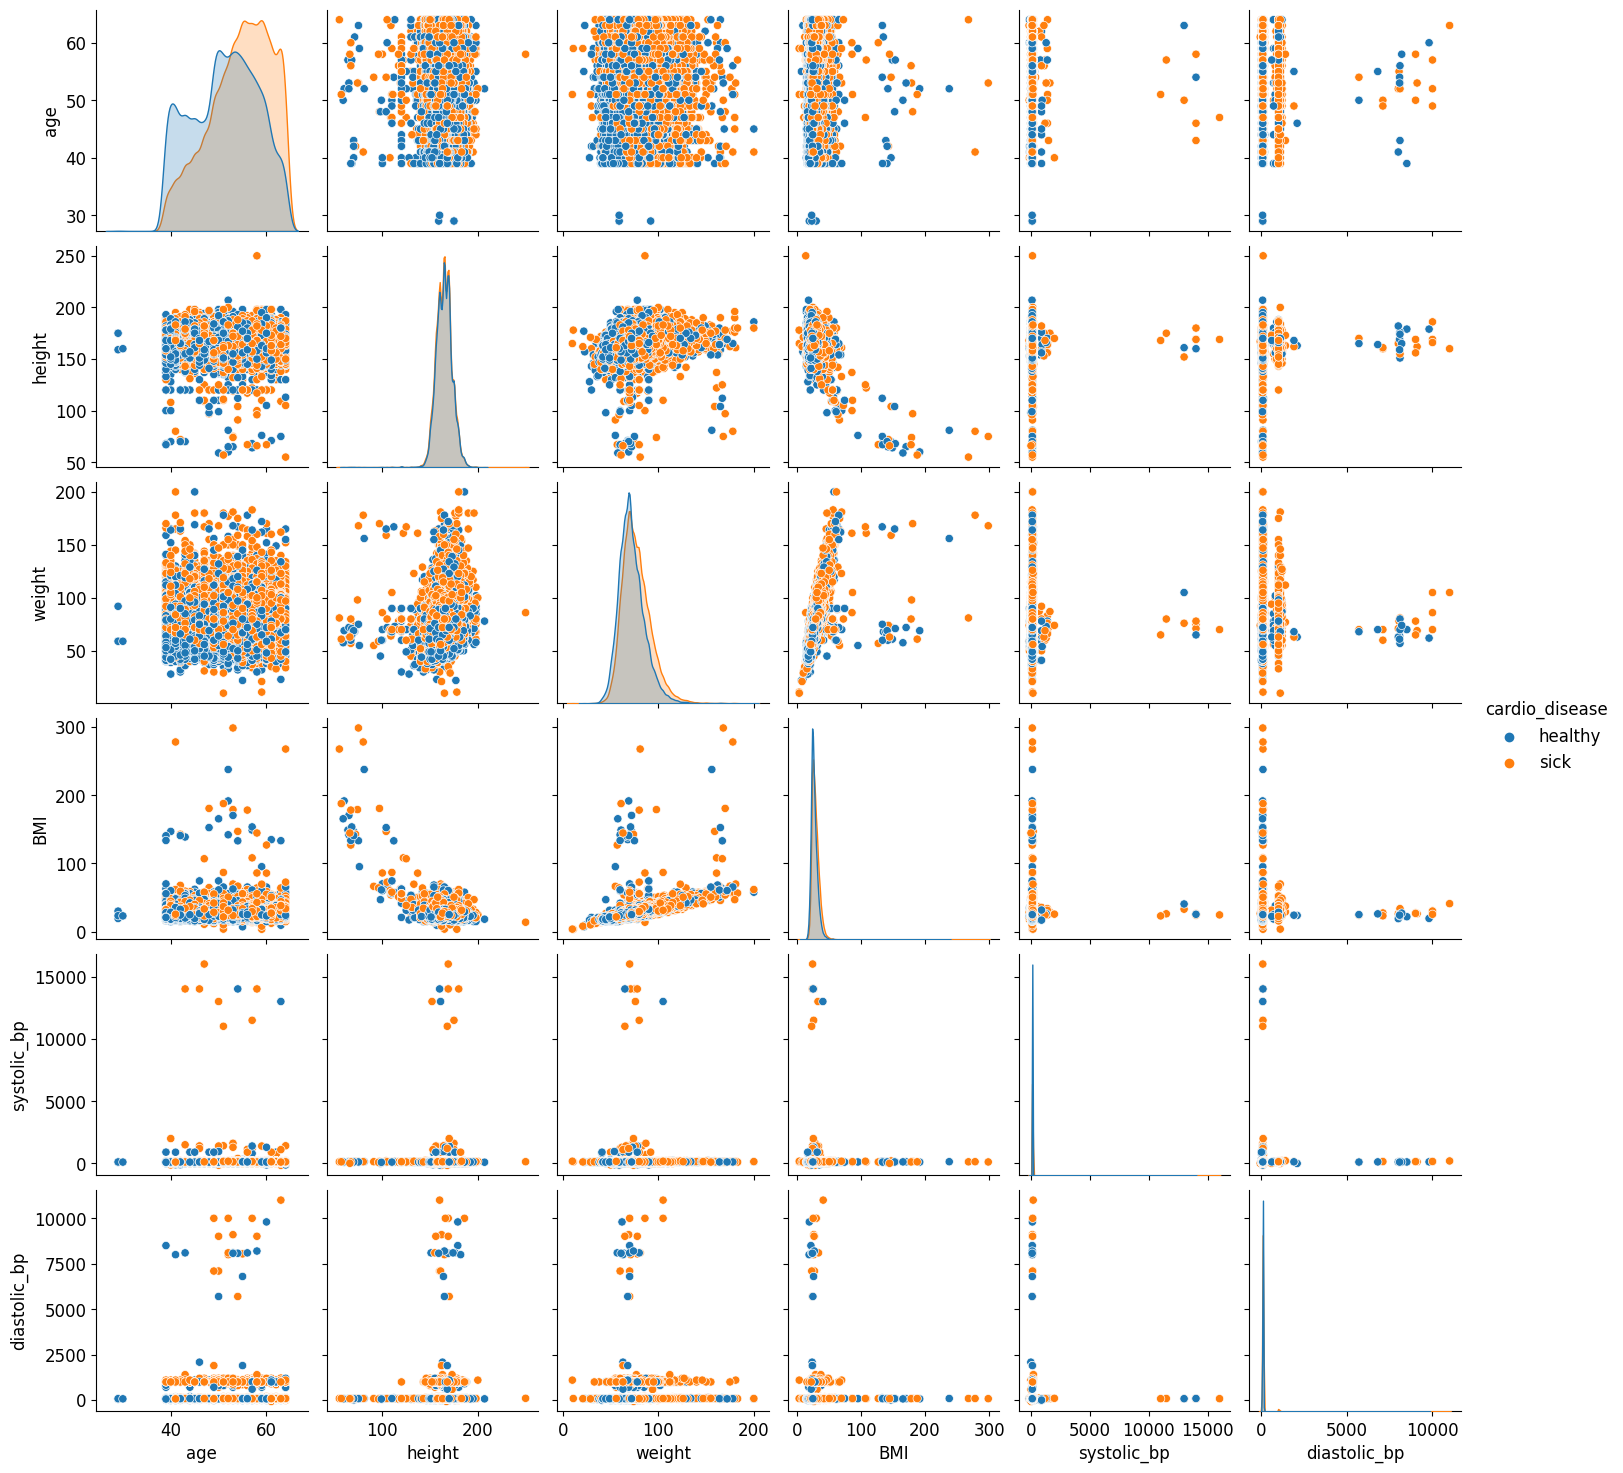

In [45]:
sns.pairplot(data=df[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp", "cardio_disease"]], hue='cardio_disease')
plt.show()

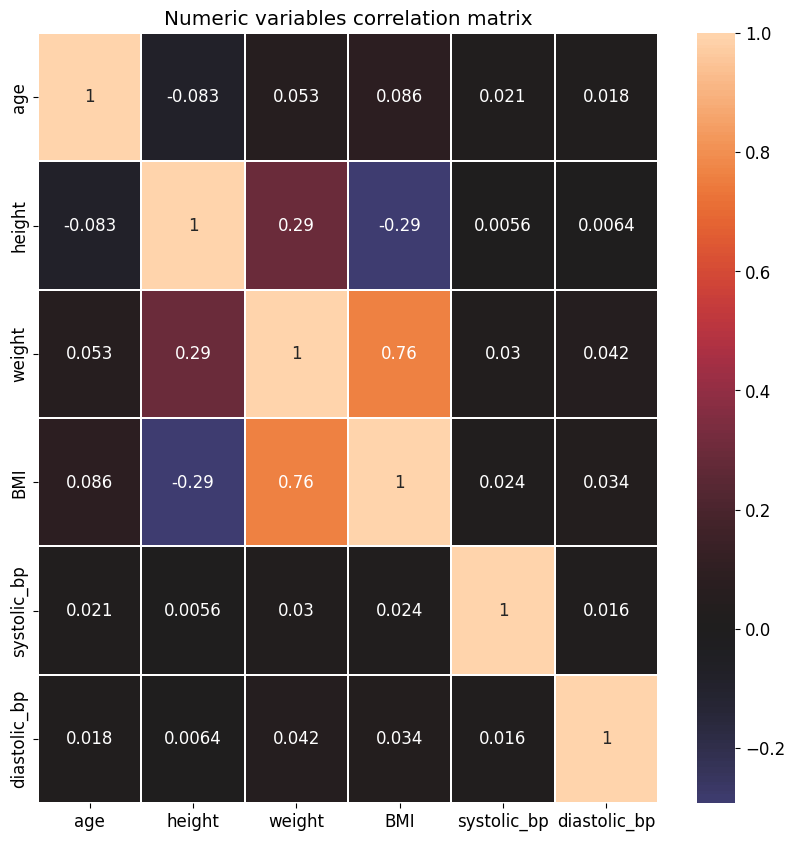

In [42]:
ax = sns.heatmap(df[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]].corr(), annot=True, fmt=".2g", linewidths=.1, center=0)
ax.set_title("Numeric variables correlation matrix")

plt.show()

**Analizing relationship between ap_hi and ap_lo**

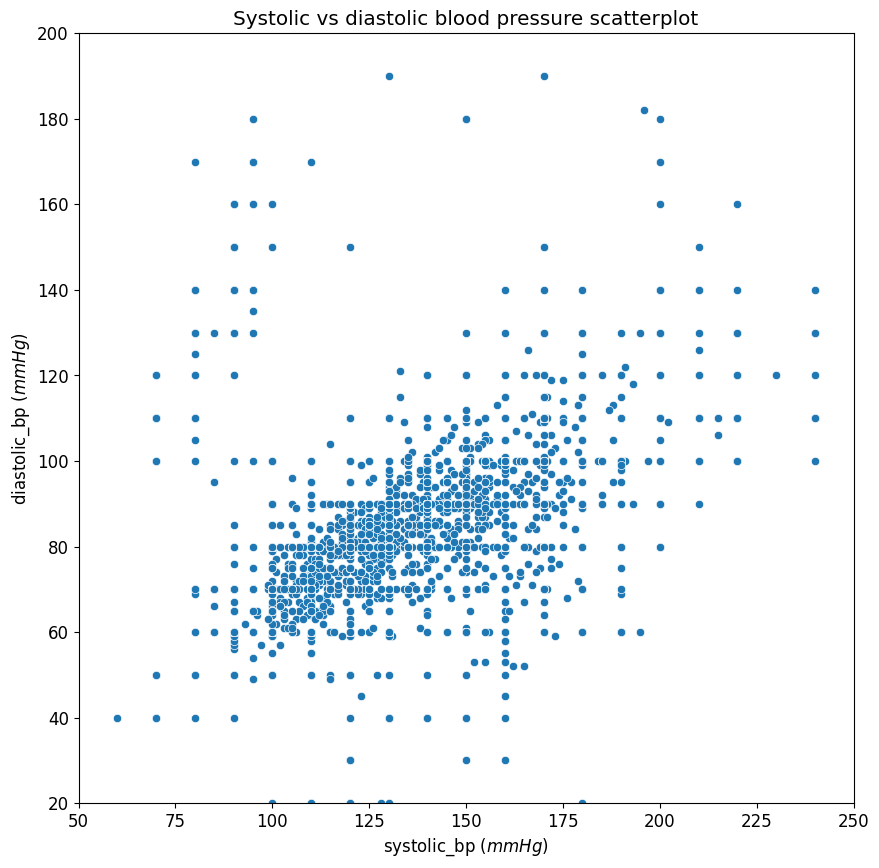

In [187]:
ax = sns.scatterplot(data=df, x="systolic_bp", y="diastolic_bp")
ax.set_xlim(50, 250)
ax.set_ylim(20, 200)
ax.set_xlabel("systolic_bp ($mm Hg$)")
ax.set_ylabel("diastolic_bp ($mm Hg$)")
ax.set_title("Systolic vs diastolic blood pressure scatterplot")

plt.show()

In [203]:
# removing systolic_bp and diastolic_bp outliers
df_cleaned = df.copy()
df_cleaned = df_cleaned[(np.abs(stats.zscore(df_cleaned["systolic_bp"])) < 1.5)]
df_cleaned = df_cleaned[df_cleaned.systolic_bp > 0]
df_cleaned = df_cleaned[(np.abs(stats.zscore(df_cleaned["diastolic_bp"])) < 1.5)]
df_cleaned = df_cleaned[df_cleaned.diastolic_bp > 0]

print("Original dataset: {}".format(round(np.corrcoef(df["systolic_bp"], df["diastolic_bp"])[0][1], 3)))
print("Dataset without outliers: {}".format(round(np.corrcoef(df_cleaned["systolic_bp"], df_cleaned["diastolic_bp"])[0][1], 3)))

display(df.shape)
display(df_cleaned.shape)


Original dataset: 0.016
Dataset without outliers: 0.649


(66792, 13)

(65777, 13)

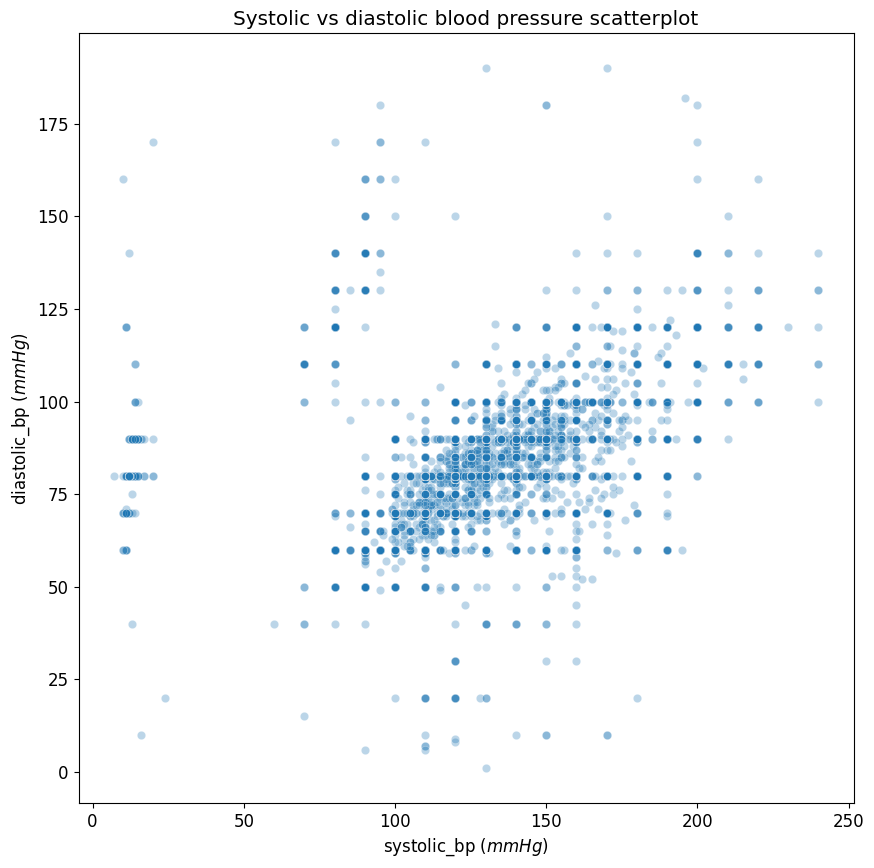

In [215]:
ax = sns.scatterplot(data=df_cleaned, x="systolic_bp", y="diastolic_bp", alpha=0.3)
ax.set_xlabel("systolic_bp ($mm Hg$)")
ax.set_ylabel("diastolic_bp ($mm Hg$)")
ax.set_title("Systolic vs diastolic blood pressure scatterplot")

plt.show()

As it can be seen from the scatterplot the two variables that represent the patient blood pressure are very correlated, but this correlation is hidden in the original data due to outliers presence.

**Analizing relationship between BMI, weight and height**

In [210]:
# removing height and weight outliers
display(df_cleaned.shape)

df_cleaned = df_cleaned[(np.abs(stats.zscore(df_cleaned["height"])) < 4)]
df_cleaned = df_cleaned[(np.abs(stats.zscore(df_cleaned["weight"])) < 4)]

display(df_cleaned.shape)

(65493, 13)

(65464, 13)

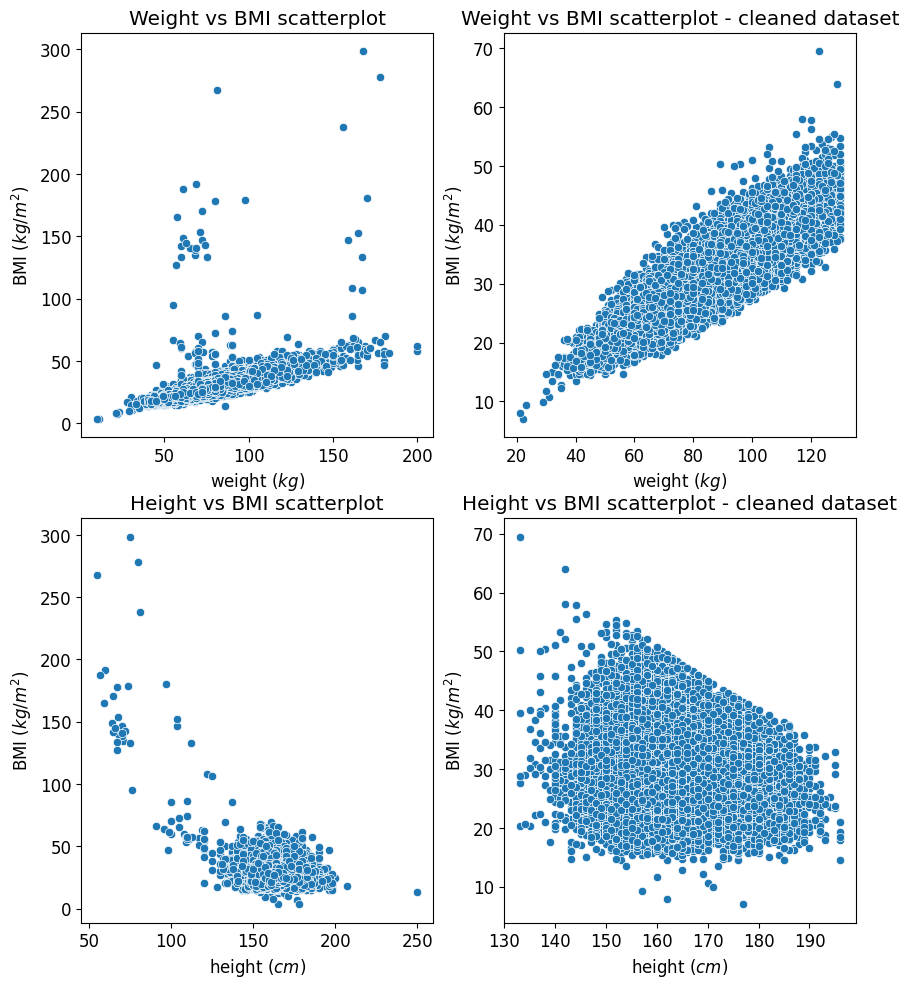

In [211]:
plt.subplot(2, 2, 1)
ax = sns.scatterplot(data=df, x="weight", y="BMI")
ax.set_xlabel("weight ($kg$)")
ax.set_ylabel("BMI ($kg/m^2$)")
ax.set_title("Weight vs BMI scatterplot")

plt.subplot(2, 2, 2)
ax = sns.scatterplot(data=df_cleaned, x="weight", y="BMI")
ax.set_xlabel("weight ($kg$)")
ax.set_ylabel("BMI ($kg/m^2$)")
ax.set_title("Weight vs BMI scatterplot - cleaned dataset")

plt.subplot(2, 2, 3)
ax = sns.scatterplot(data=df, x="height", y="BMI")
ax.set_xlabel("height ($cm$)")
ax.set_ylabel("BMI ($kg/m^2$)")
ax.set_title("Height vs BMI scatterplot")

plt.subplot(2, 2, 4)
ax = sns.scatterplot(data=df_cleaned, x="height", y="BMI")
ax.set_xlabel("height ($cm$)")
ax.set_ylabel("BMI ($kg/m^2$)")
ax.set_title("Height vs BMI scatterplot - cleaned dataset")

plt.subplots_adjust(top=1)
plt.show()

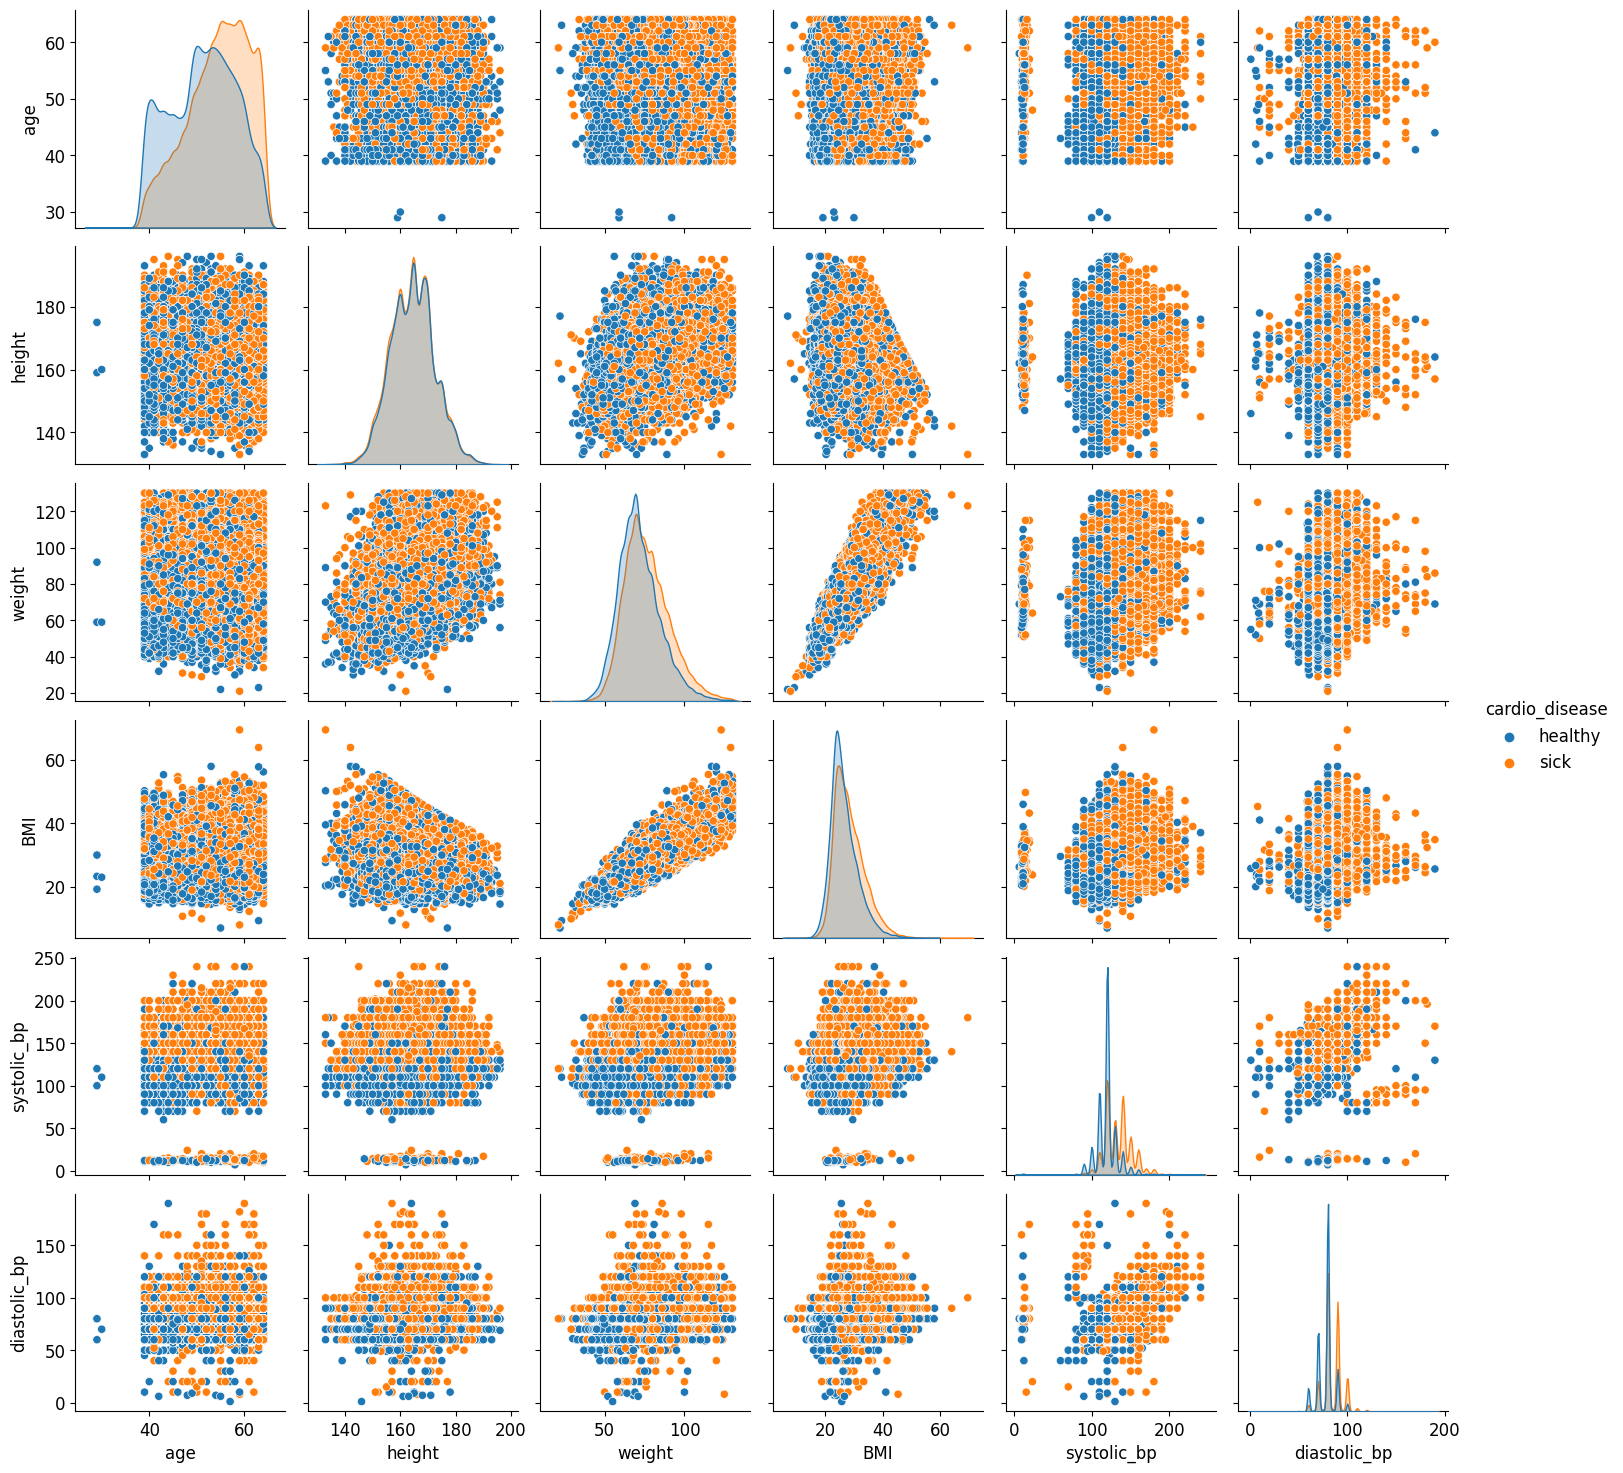

In [212]:
sns.pairplot(data=df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp", "cardio_disease"]], hue='cardio_disease')
plt.show()

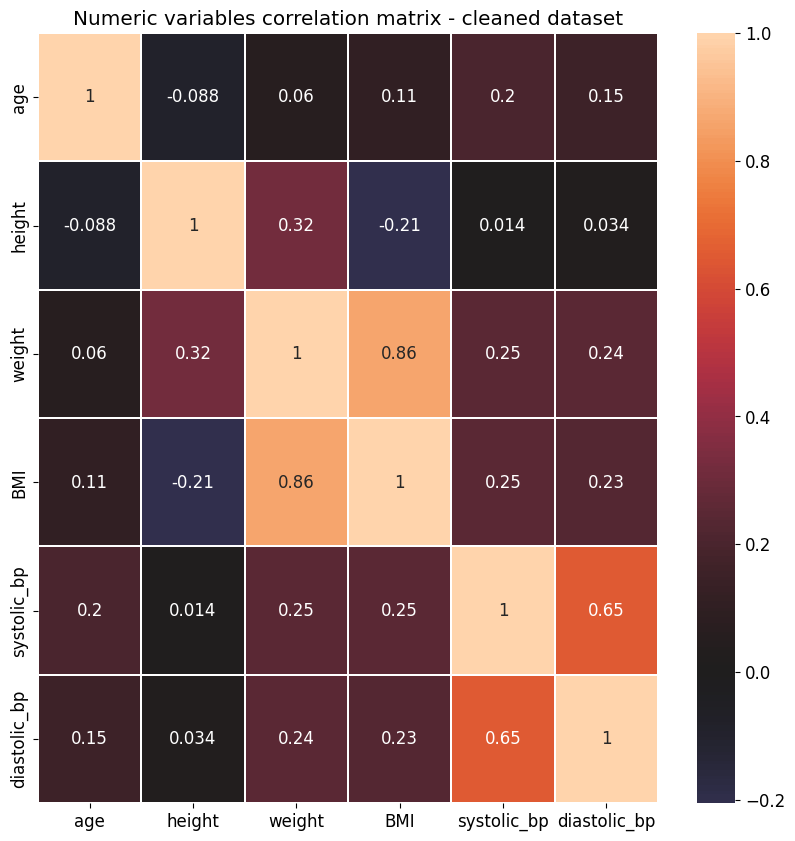

In [216]:
ax = sns.heatmap(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]].corr(), annot=True, fmt=".2g", linewidths=.1, center=0)
ax.set_title("Numeric variables correlation matrix - cleaned dataset")

plt.show()

In [52]:
df = map_values(df, to_numeric=True)
df_cleaned = map_values(df_cleaned, to_numeric=True)

## Data visualization

PCA

In [ ]:
df.head()

age  gender  height  weight        BMI  ap_hi  ap_lo  cholesterol  glucose  \
id                                                                            
0    50       1     168    62.0  21.967120    110     80            1     1   
1    55       0     156    85.0  34.927679    140     90            3     1   
2    51       0     165    64.0  23.507805    130     70            3     1   
3    48       1     169    82.0  28.710479    150    100            1     1   
4    47       0     156    56.0  23.011177    100     60            1     1   

    smoke  alco  active  cardio_disease  
id                               
0       0     0       1       0  
1       0     0       1       1  
2       0     0       0       1  
3       0     0       1       1  
4       0     0       0       0

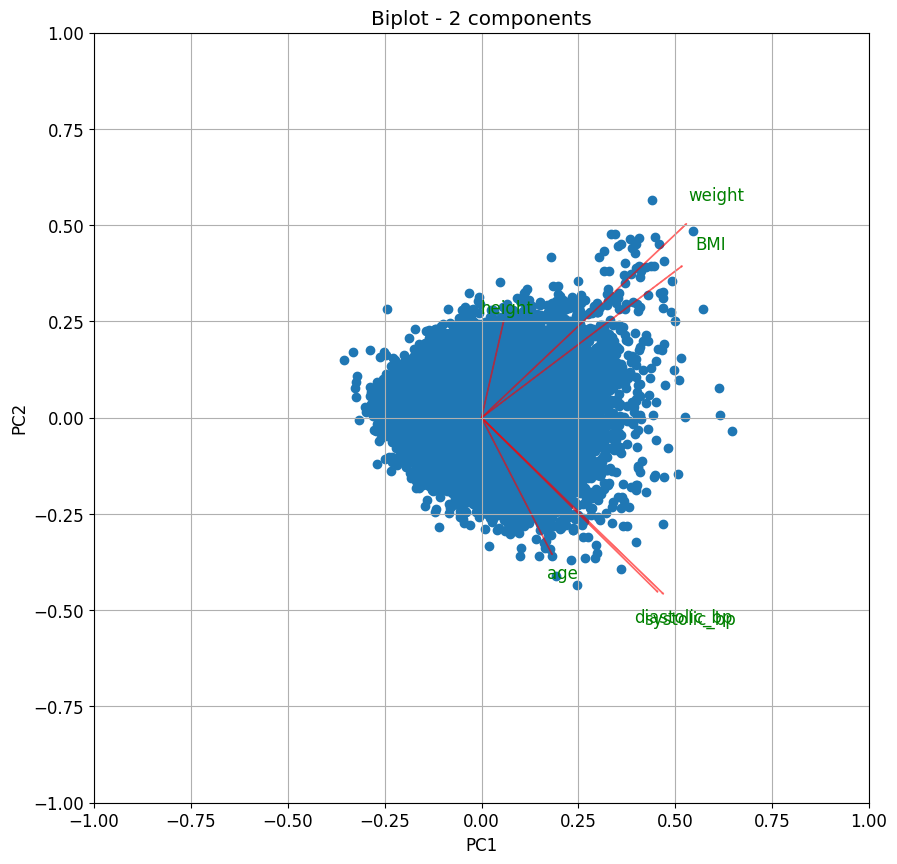

In [53]:
scaler = StandardScaler()
scaler.fit(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])
df_1 = scaler.transform(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])

pca = PCA(n_components=2)
df_1_reduced = pca.fit_transform(df_1)

def biplot(score, coeff, labels=["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs * scalex, ys * scaley) # Display data points
    
    # Diplay arrows and labels
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var" + tr(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    # Plot settings
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.title("Biplot - 2 components")
    plt.grid()

#Call the function. Use only the 2 PCs.
biplot(df_1_reduced[:,0:2], np.transpose(pca.components_[0:2, :]))
plt.show()

In [54]:
display(pca.explained_variance_ratio_)

array([0.39294774, 0.22136774])

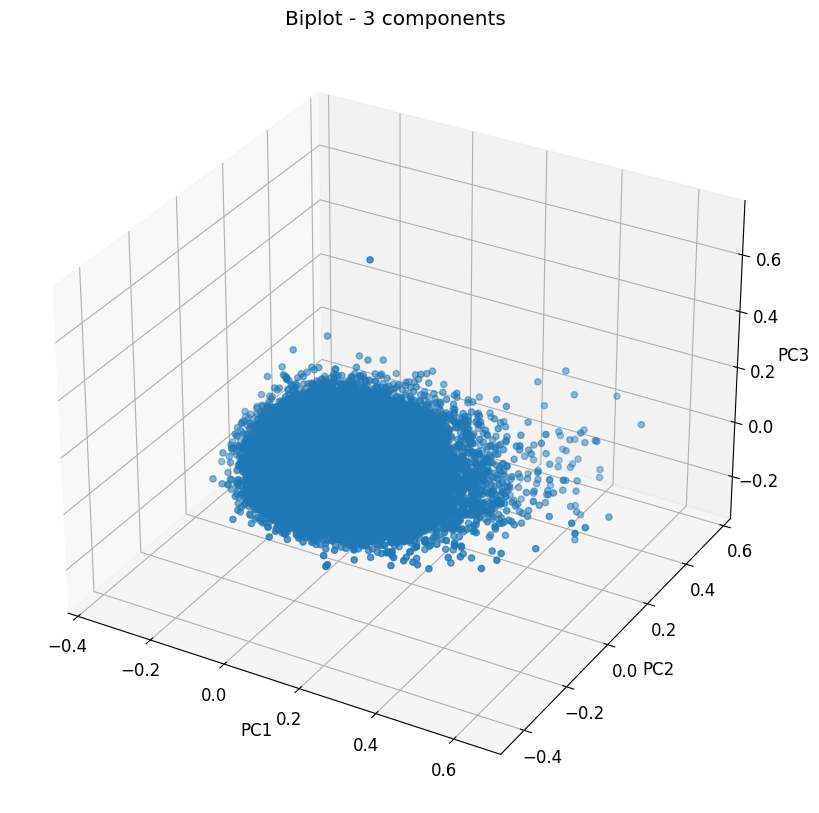

In [56]:
scaler = StandardScaler()
scaler.fit(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])
df_1 = scaler.transform(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])

pca = PCA(n_components=3)
df_1_reduced = pca.fit_transform(df_1)

def biplot(score, coeff, labels=["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]):
    xs = score[:,0]
    ys = score[:,1]
    zs = score[:,2]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    scalez = 1.0/(zs.max() - zs.min())
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs * scalex, ys * scaley, zs * scalez)
    '''
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, coeff[i,2] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, coeff[i,2] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    
    ax.xlim(-1,1)
    ax.ylim(-1,1)
    ax.zlim(-1,1)
    '''
    
    ax.set_xlabel("PC{}".format(1))
    ax.set_ylabel("PC{}".format(2))
    ax.set_zlabel("PC{}".format(3))
    ax.grid()
    ax.set_title("Biplot - 3 components")

#Call the function. Use only the 3 PCs.
biplot(df_1_reduced[:,0:3], np.transpose(pca.components_[0:3, :]))

plt.show()

In [59]:
display(pca.explained_variance_ratio_)

array([0.39294774, 0.22136774, 0.19009624])

## Data preprocessing

In [60]:
for col in df_cleaned.columns:
    if col != "cardio_disease":
        print("Variance of {}: {}".format(col, np.var(df_cleaned[col])))

Variance of age: 46.31484055316192
Variance of gender: 0.23018551397976625
Variance of height: 59.12582046773201
Variance of weight: 207.73962670341993
Variance of BMI: 27.293472413480963
Variance of systolic_bp: 289.13160453232285
Variance of diastolic_bp: 94.39472516375145
Variance of cholesterol: 0.4737602334735077
Variance of glucose: 0.33871571383826526
Variance of smoke: 0.084378125928761
Variance of alcool_intake: 0.053258743507039415
Variance of physical_activity: 0.16112842850257955


One hot encoding cholesterol and glucose features

In [ ]:
encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(df_cleaned[["cholesterol"]]).toarray()
items = [f'{"cholesterol"}_{item}' for item in encoder.categories_[0]]
df_cleaned[items] = onehotarray

onehotarray = encoder.fit_transform(df_cleaned[["glucose"]]).toarray()
items = [f'{"glucose"}_{item}' for item in encoder.categories_[0]]
df_cleaned[items] = onehotarray

df_cleaned = df_cleaned.drop(columns=["cholesterol", "glucose"])

Scaling datasets

In [67]:
scaler = StandardScaler()
scaler.fit(df[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])
df[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]] = scaler.transform(df[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])

scaler.fit(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])
df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]] = scaler.transform(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])


In [68]:
df_cleaned.head()

age  gender    height    weight       BMI  systolic_bp  diastolic_bp  \
id                                                                              
0  -0.414588       1  0.432878 -0.871779 -1.064589    -0.994345     -0.147134   
1   0.320112       0 -1.127726  0.723983  1.416226     0.769959      0.882129   
2  -0.267648       0  0.042727 -0.733017 -0.769683     0.181858     -1.176396   
3  -0.708468       1  0.562928  0.515841  0.226175     1.358061      1.911391   
4  -0.855408       0 -1.127726 -1.288065 -0.864744    -1.582446     -2.205659   

    smoke  alcool_intake  physical_activity  cardio_disease  cholesterol_1  \
id                                                                           
0       0              0                  1               0            1.0   
1       0              0                  1               1            0.0   
2       0              0                  0               1            0.0   
3       0              0                  1               1            1.0   
4       0              0                  0               0            1.0   

    cholesterol_2  cholesterol_3  glucose_1  glucose_2  glucose_3  
id                                                                 
0             0.0            0.0        1.0        0.0        0.0  
1             0.0            1.0        1.0        0.0        0.0  
2             0.0            1.0        1.0        0.0        0.0  
3             0.0            0.0        1.0        0.0        0.0  
4             0.0            0.0        1.0        0.0        0.0

## Predictive analysis

Train test split

In [69]:
#dividing the dataset into two sets: train set and test set
def tt_split(dataframe):
  x = dataframe.loc[:, dataframe.columns!='cardio_disease']
  y = dataframe['cardio_disease']
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

  return X_train, X_test, y_train, y_test

Classification

In [70]:
classifiers = {
    "Decision Tree": (DecisionTreeClassifier(), {"predict_proba": True}, {'criterion': ("gini", "entropy"), 
                                                                           'splitter': ("best", "random"),
                                                                           'class_weight': ["balanced"],
                                                                           'random_state': [1] }),

    "Random Forest": (RandomForestClassifier(), {"predict_proba": True},  {'n_estimators': [100],
                                                                           'criterion': ("gini", "entropy"), 
                                                                           'class_weight': ["balanced"],
                                                                           'max_features': ("sqrt", "log2"),
                                                                           'random_state': [1] }),

    "XGBClassifier": (XGBClassifier(), {"predict_proba": True}, {'n_estimators': [100],
                                                                 'learning_rate': (0.01, 0.05, 0.10, 0.20, 0.30),
                                                                 'max_depth': (3, 4, 5, 8, 10, 12, 15),
                                                                 'min_child_weight': (1, 3, 5, 7),
                                                                 'tree_method': ("exact", "approx", "hist"),
                                                                 'random_state': [1] }),

    "Nearest Neighbors": (KNeighborsClassifier(), {"predict_proba": True}, {'n_neighbors': (5, 7, 9), 
                                                                            'weights': ("uniform", "distance"),
                                                                            'algorithm': ("ball_tree", "kd_tree"),
                                                                            'p': (1, 2, 3),
                                                                            'n_jobs': [-1] }),

    "Naive Bayes": (GaussianNB(), {"predict_proba": True}, None),

    #"SVC": (SVC(), {"predict_proba": True}, {'kernel': ("linear", "poly", "rbf"), 
    #                                         'C': (1, 5, 10),
    #                                         'random_state': [1] }),

    "LinearSVC": (LinearSVC(), {"predict_proba": False}, {'penalty': ('l1', 'l2'), 
                                                          'C': (1, 5, 10),
                                                          'tol': (1e-4, 1e-3, 1e-2),
                                                          'dual': [False],
                                                          'random_state': [1] }),

    "Kmeans": (KMeans(), {"predict_proba": False}, {'n_clusters': [2],
                                                    'init': ("k-means++", "random"),
                                                    'algorithm': ("lloyd", "elkan"),
                                                    'random_state': [1] }),

    #"MLPClassifier": (MLPClassifier(), {"predict_proba": True}, {'hidden_layer_sizes': [(64,32,16,32)], 
    #                                                             'activation': ["relu"], 
    #                                                             'random_state': [1] })
}

In [72]:
result_matrixes = dict()

def classification(classifiers, X_train, y_train, X_test, y_test, n_iter):
  result_matrix = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"])

  for name, clf in classifiers.items():
    print("Classifier: ", name)

    # Hyperparameters optimization
    if clf[2] != None:
      if len(list(ParameterGrid(clf[2]))) < n_iter:
        classifier = GridSearchCV(clf[0], clf[2], n_jobs=-1)
      else: classifier = RandomizedSearchCV(clf[0], clf[2], n_jobs=-1, n_iter=n_iter)
      classifier.fit(X_train, y_train)
      print("Best hyperparameters : {}".format(classifier.best_params_))
    else: 
      classifier = clf[0]
      classifier.fit(X_train, y_train)
    
    # Predicion task handled by the best estimator found by the hyperparameter cross validator
    y_pred = classifier.predict(X_test)
            
    # Getting predicted probabilities
    if clf[1]["predict_proba"] == True:
      y_score1 = classifier.predict_proba(X_test)[:,1]
      #display("Predicted probability: ", y_score1)

    pr, rc, fs, sup = metrics.precision_recall_fscore_support(y_test, y_pred, average='macro')
    result_matrix = pd.concat([result_matrix, pd.DataFrame({"Classifier": name,
                                                            "Accuracy": round(metrics.accuracy_score(y_test, y_pred), 4),
                                                            "Precision": round(pr, 4), 
                                                            "Recall": round(rc, 4),
                                                            "F1-Score": round(fs, 4),
                                                            "ROC AUC": roc_auc_score(y_test, y_score1) if clf[1]["predict_proba"] else None }, index=[0])])

    # Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')
      
    # ROC AUC curve
    if name != "Kmeans":
      RocCurveDisplay.from_estimator(classifier, X_test, y_test)  
      plt.show()


  result_matrix.set_index("F1-Score", inplace=True)
  result_matrix.sort_values(by="F1-Score", ascending=False, inplace=True)
  
  return result_matrix

### Plain dataset

Classifier:  Decision Tree
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'best'}


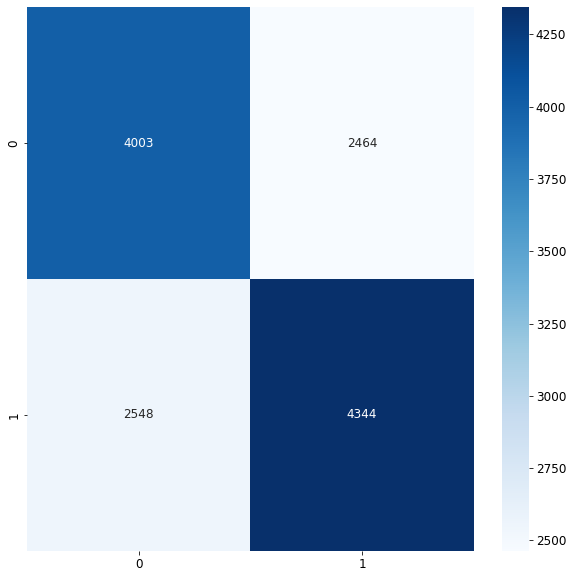

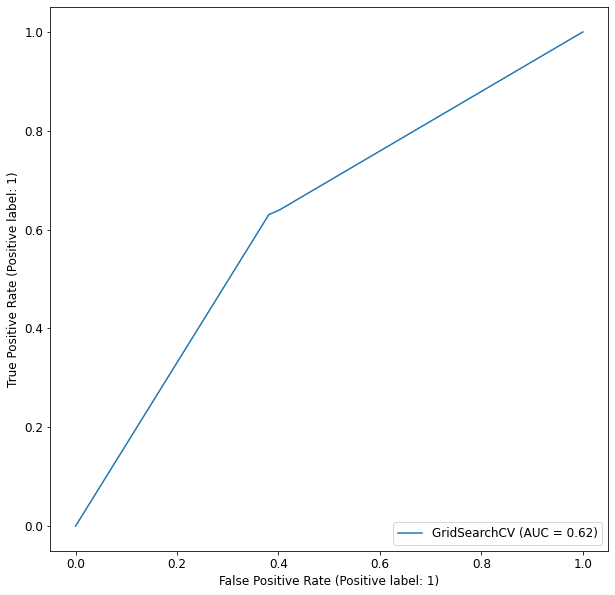

Classifier:  Random Forest
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


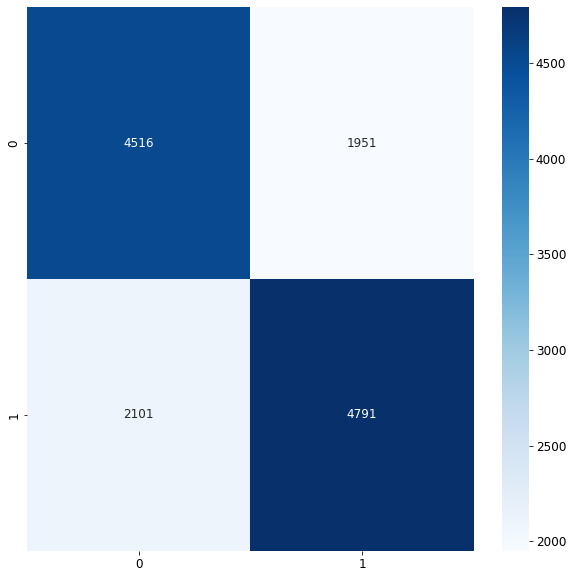

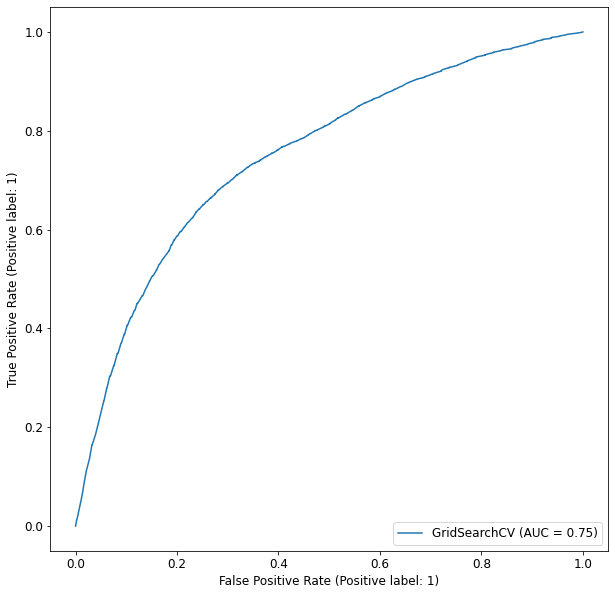

Classifier:  XGBClassifier
Best hyper parameters : {'tree_method': 'hist', 'random_state': 1, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.3}


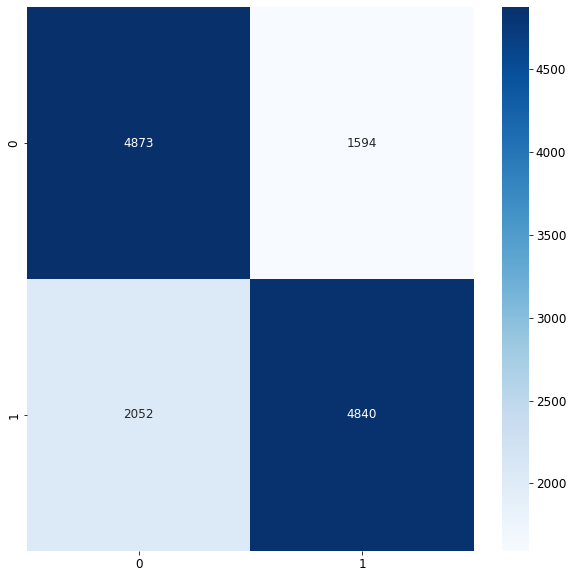

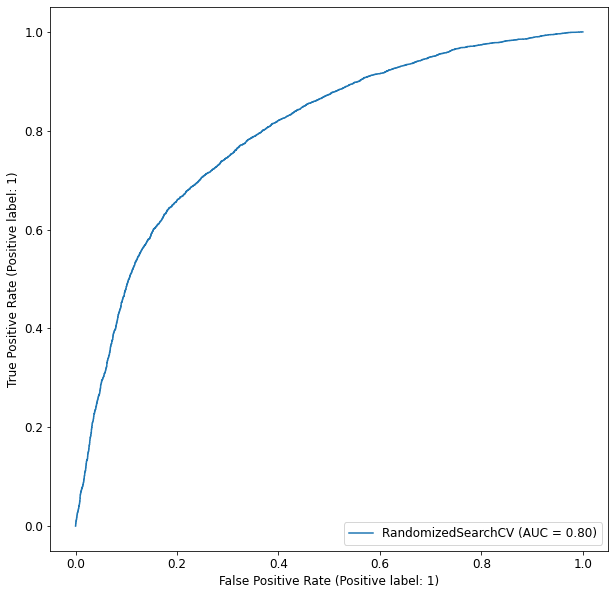

Classifier:  Nearest Neighbors
Best hyper parameters : {'weights': 'uniform', 'p': 1, 'n_neighbors': 7, 'n_jobs': -1, 'algorithm': 'kd_tree'}


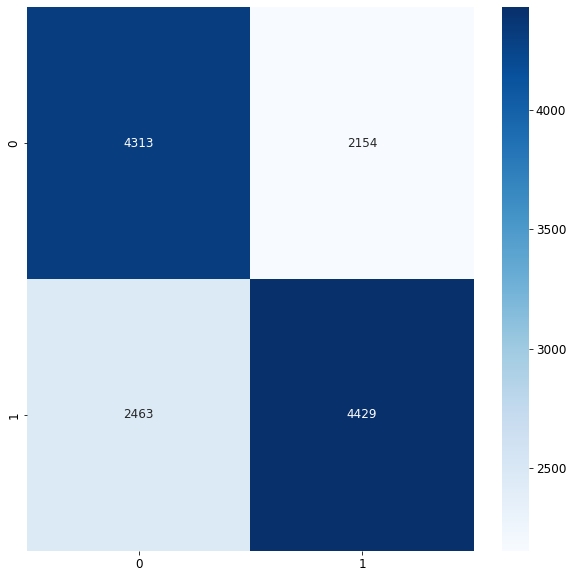

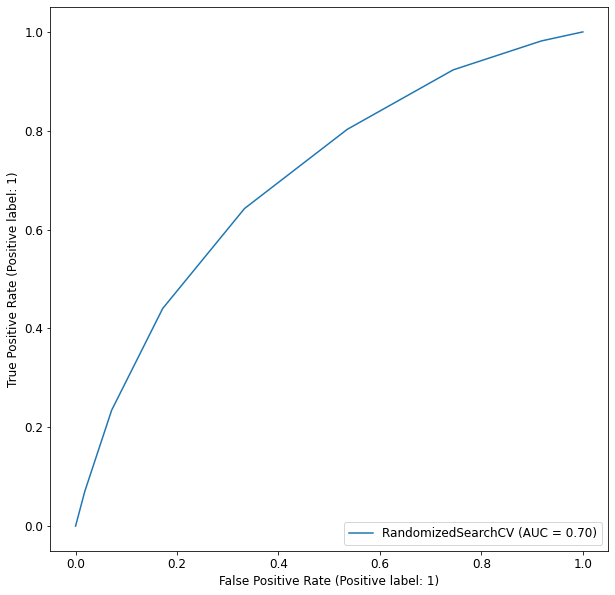

Classifier:  Naive Bayes


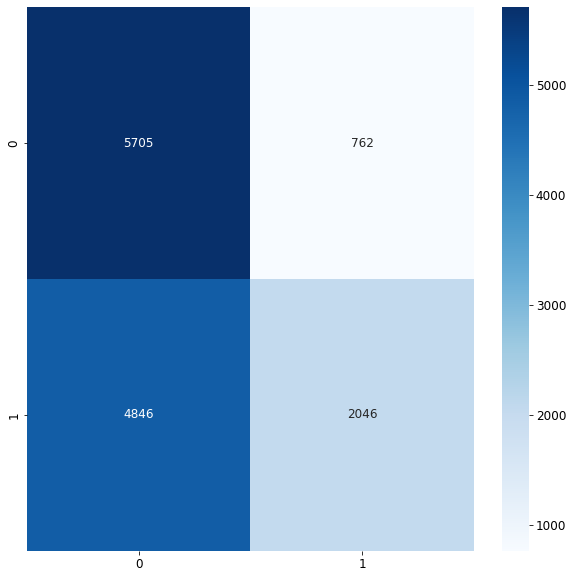

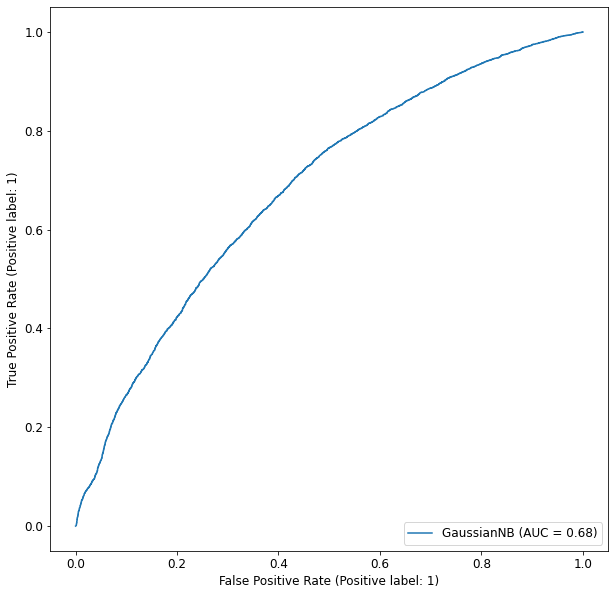

Classifier:  LinearSVC
Best hyper parameters : {'tol': 0.01, 'random_state': 1, 'penalty': 'l1', 'dual': False, 'C': 5}


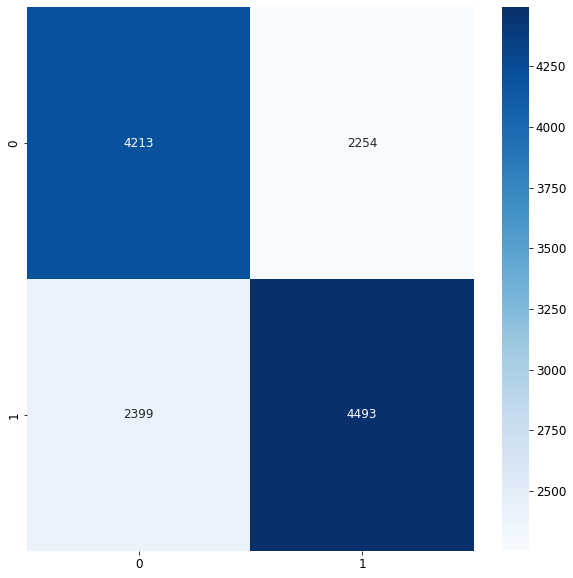

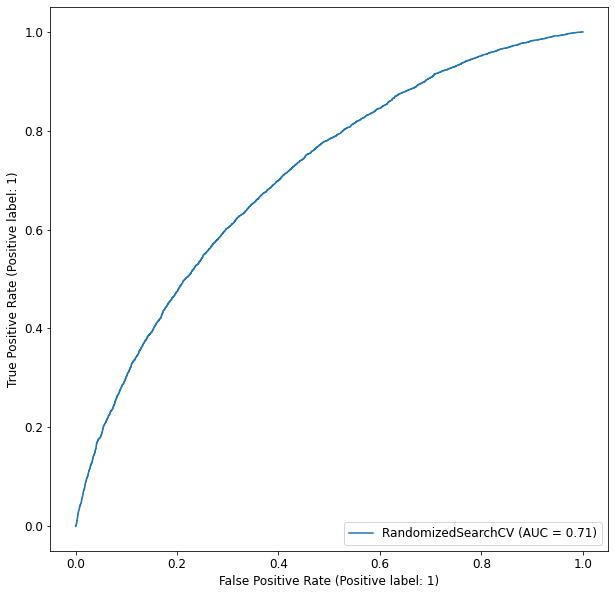

Classifier:  Kmeans
Best hyper parameters : {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2, 'random_state': 1}


c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Classifier Accuracy Precision  Recall   ROC AUC
F1-Score                                                        
0.7271        XGBClassifier   0.7271     0.728  0.7279   0.79618
0.6966        Random Forest   0.6967    0.6966  0.6967   0.75084
0.6544    Nearest Neighbors   0.6544    0.6547  0.6548  0.703156
0.6515            LinearSVC   0.6517    0.6516  0.6517      None
0.6246        Decision Tree   0.6248    0.6246  0.6246  0.623686
0.5722               Kmeans    0.583    0.6008  0.5886      None
0.5462          Naive Bayes   0.5802    0.6347  0.5895  0.682865

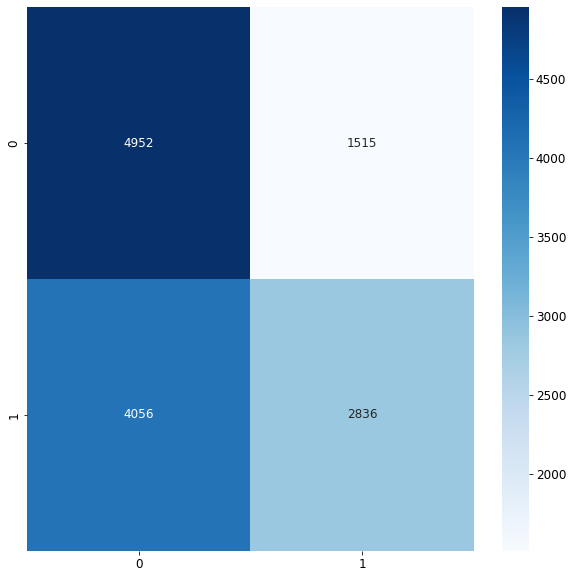

In [ ]:
X_train, X_test, y_train, y_test = tt_split(df)

result_matrixes["Plain dataset"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=5)
display(result_matrixes["Plain dataset"])

### Cleaned dataset

Classifier:  Decision Tree
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'random'}


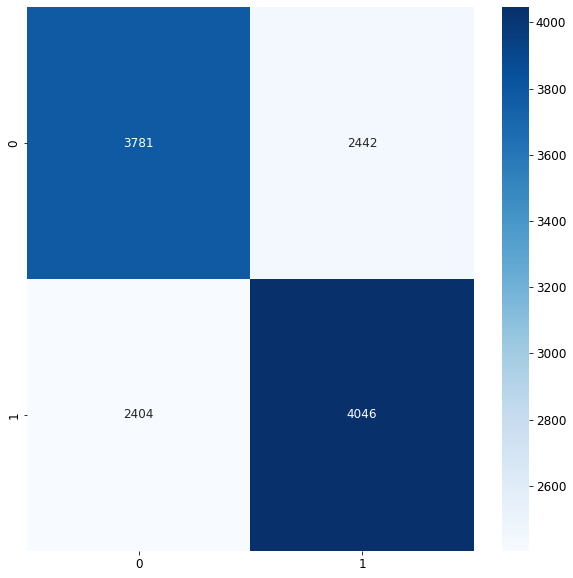

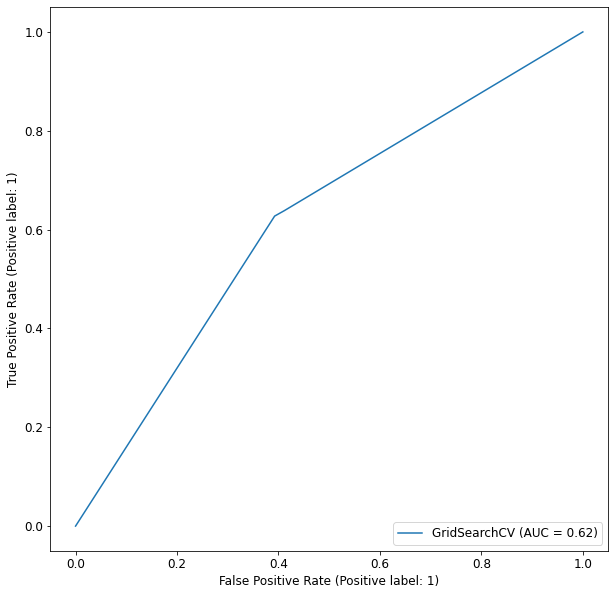

Classifier:  Random Forest
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


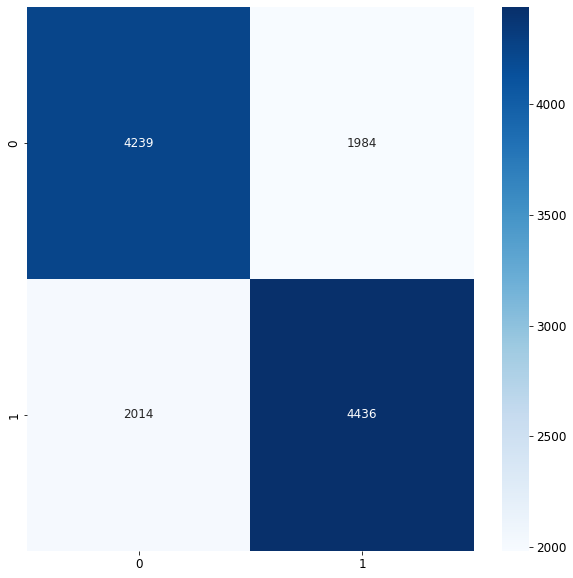

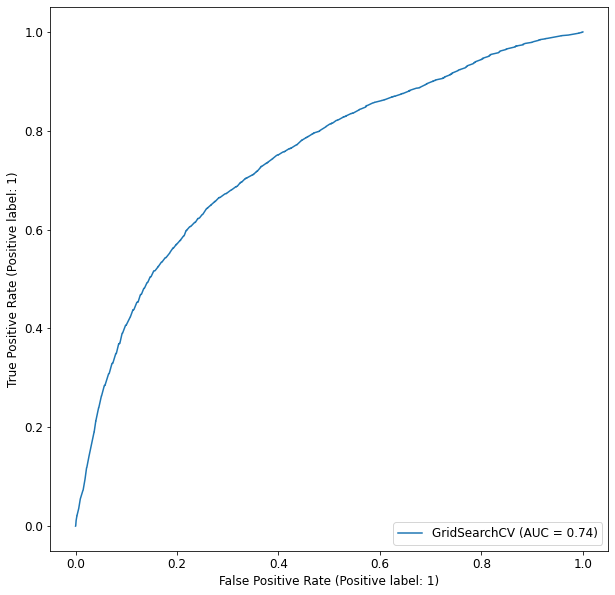

Classifier:  XGBClassifier
Best hyper parameters : {'tree_method': 'approx', 'random_state': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2}


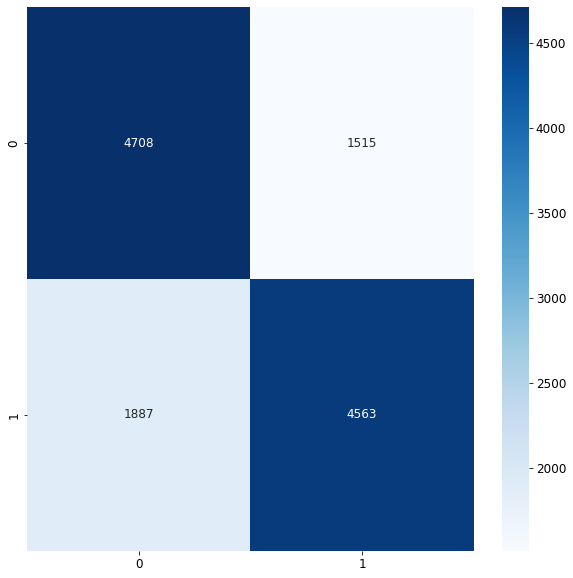

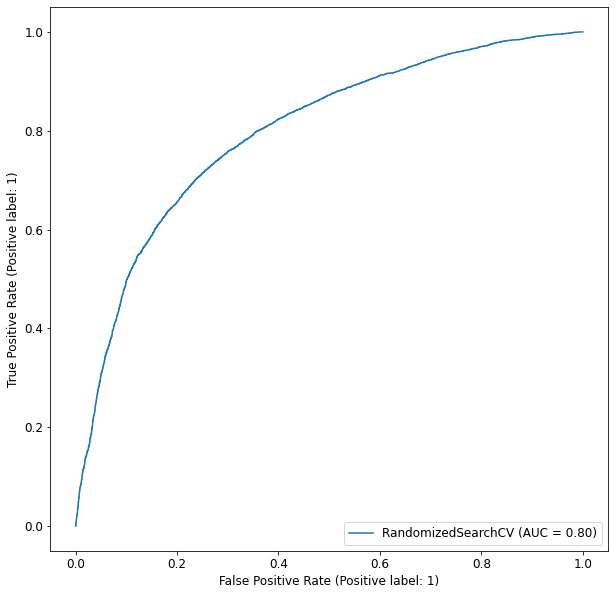

Classifier:  Nearest Neighbors
Best hyper parameters : {'weights': 'uniform', 'p': 2, 'n_neighbors': 9, 'n_jobs': -1, 'algorithm': 'kd_tree'}


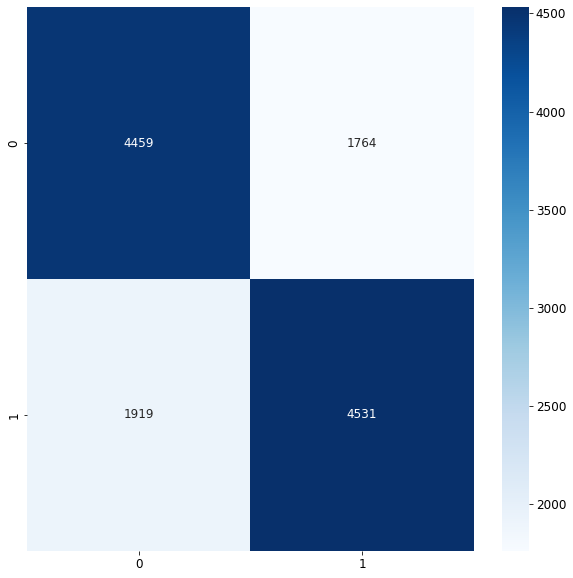

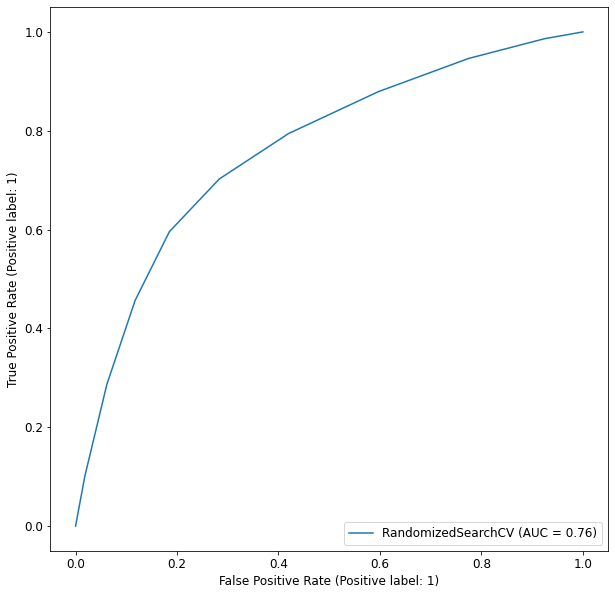

Classifier:  Naive Bayes


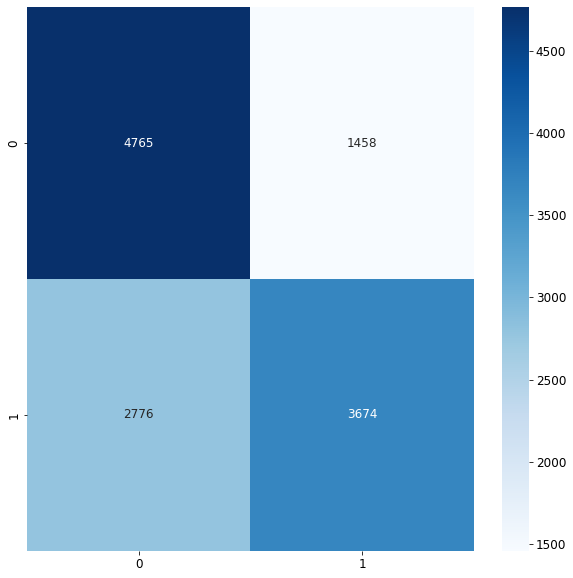

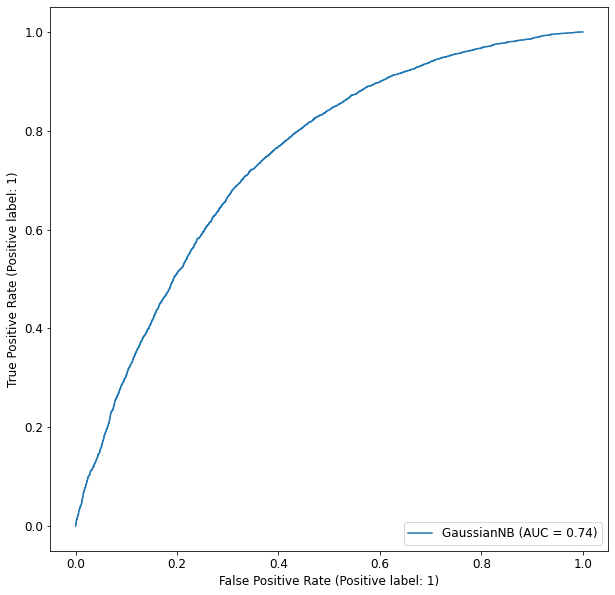

Classifier:  LinearSVC
Best hyper parameters : {'tol': 0.0001, 'random_state': 1, 'penalty': 'l2', 'dual': False, 'C': 1}


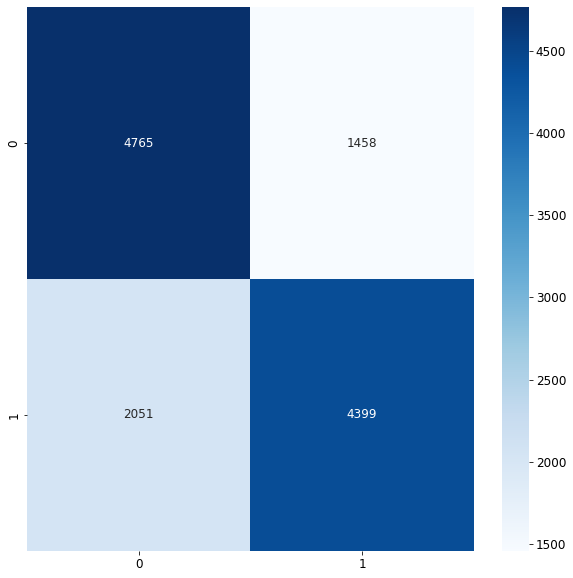

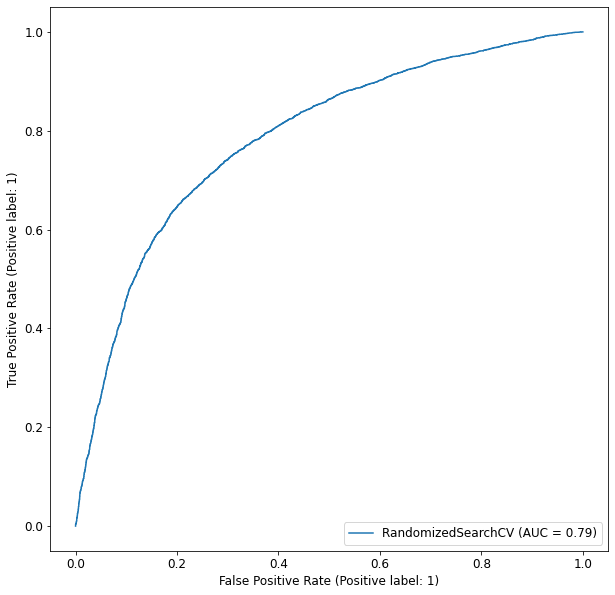

Classifier:  Kmeans
Best hyper parameters : {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2, 'random_state': 1}


c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Classifier Accuracy Precision  Recall   ROC AUC
F1-Score                                                        
0.7315        XGBClassifier   0.7316    0.7323   0.732  0.796952
0.7229            LinearSVC   0.7231    0.7251  0.7239      None
0.7094    Nearest Neighbors   0.7094    0.7094  0.7095   0.76174
0.6844        Random Forest   0.6845    0.6844  0.6845  0.744881
0.6634          Naive Bayes   0.6659    0.6739  0.6677  0.741708
0.6174        Decision Tree   0.6176    0.6175  0.6174  0.617216
0.3306               Kmeans    0.343    0.3297  0.3407      None

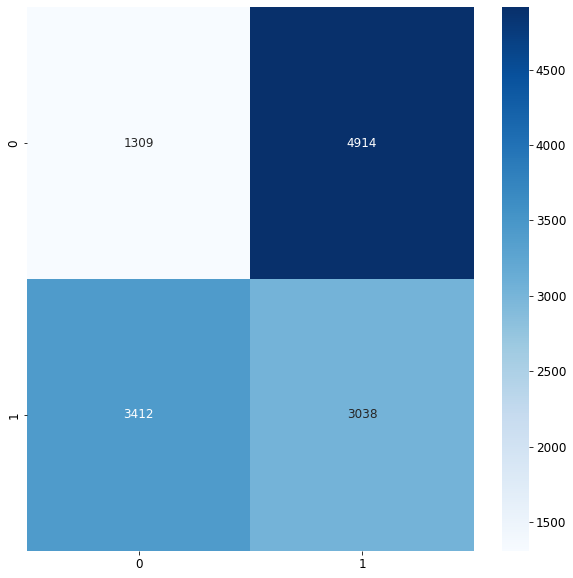

In [ ]:
X_train, X_test, y_train, y_test = tt_split(df_cleaned)

result_matrixes["Cleaned dataset"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=5)
display(result_matrixes["Cleaned dataset"])

### Cleaned dataset without smoke and alcool features

Classifier:  Decision Tree
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'best'}


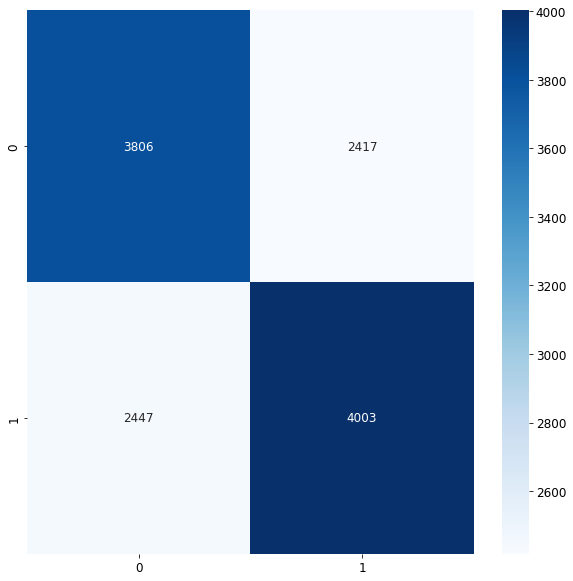

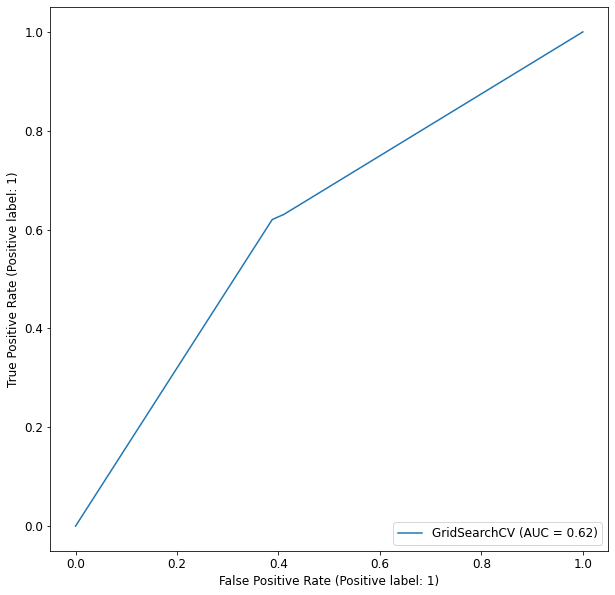

Classifier:  Random Forest
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


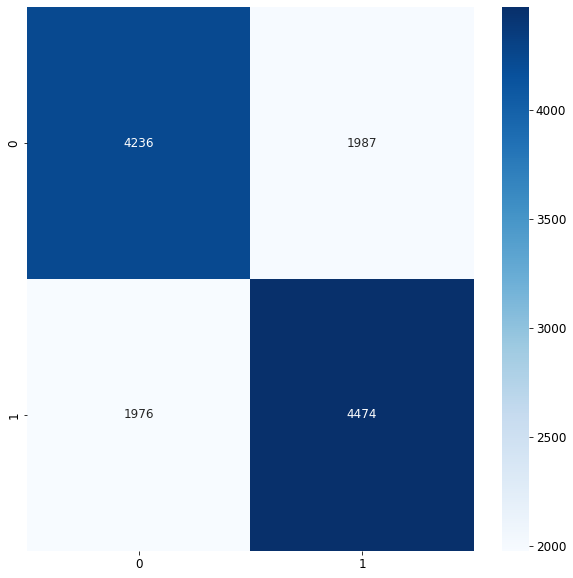

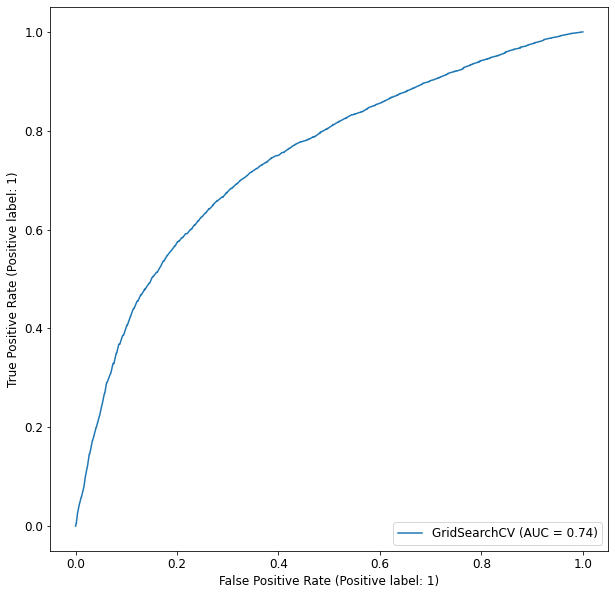

Classifier:  XGBClassifier
Best hyper parameters : {'tree_method': 'approx', 'random_state': 1, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.01}


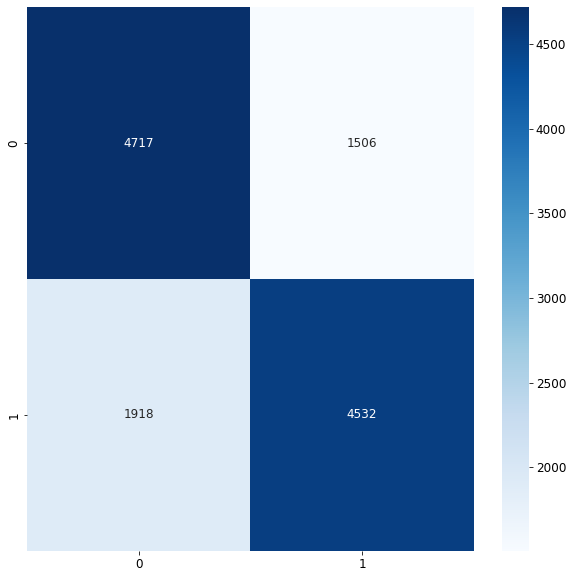

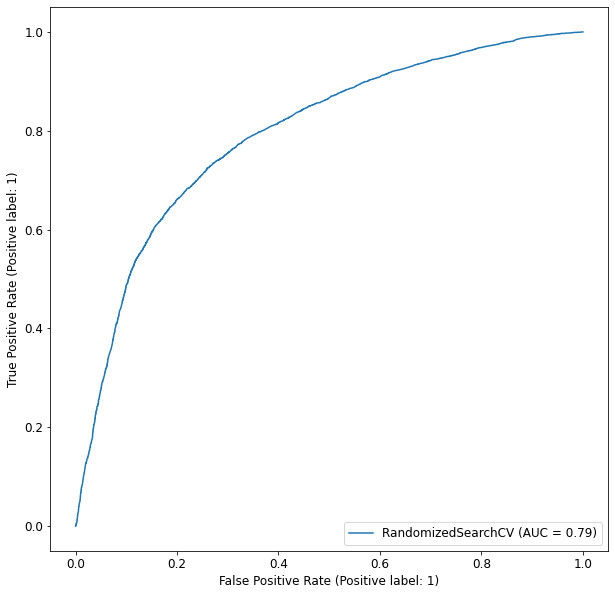

Classifier:  Nearest Neighbors
Best hyper parameters : {'weights': 'uniform', 'p': 2, 'n_neighbors': 7, 'n_jobs': -1, 'algorithm': 'ball_tree'}


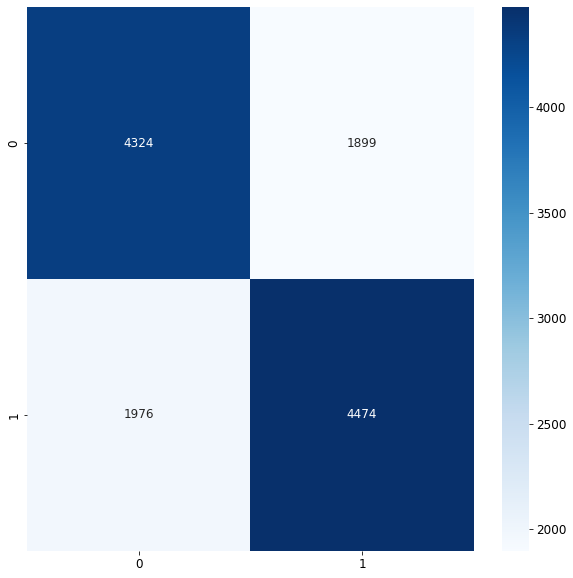

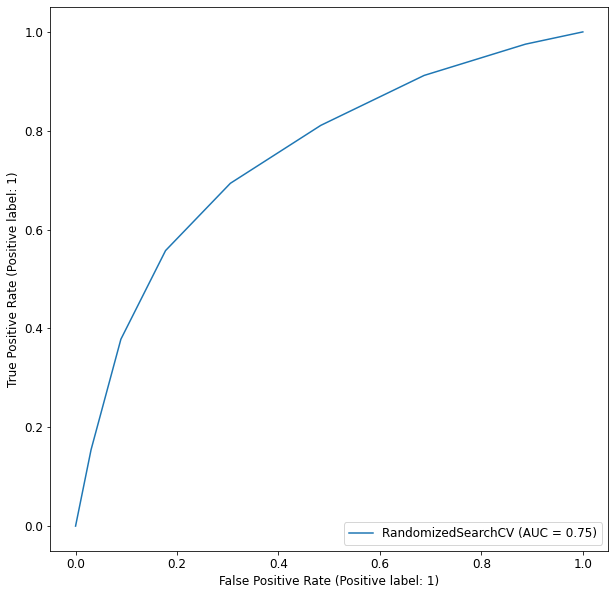

Classifier:  Naive Bayes


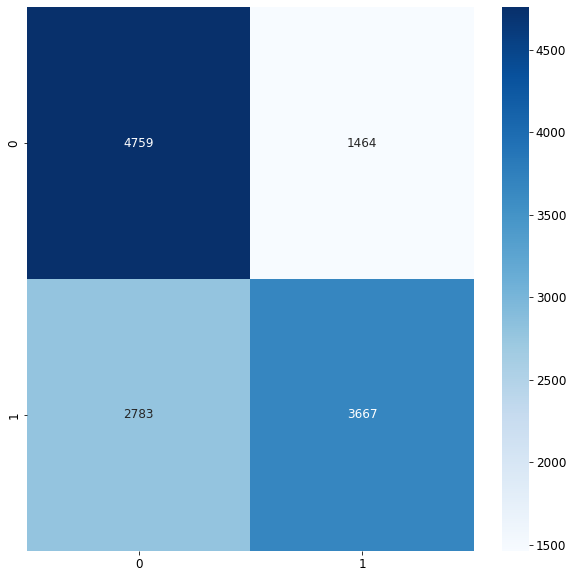

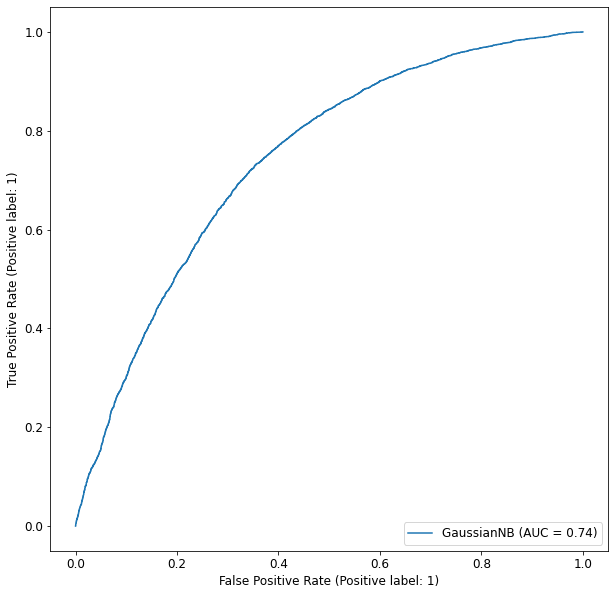

Classifier:  LinearSVC
Best hyper parameters : {'tol': 0.01, 'random_state': 1, 'penalty': 'l2', 'dual': False, 'C': 5}


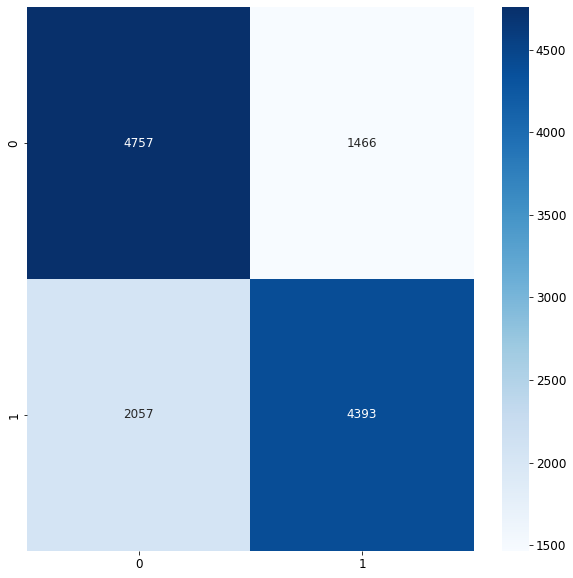

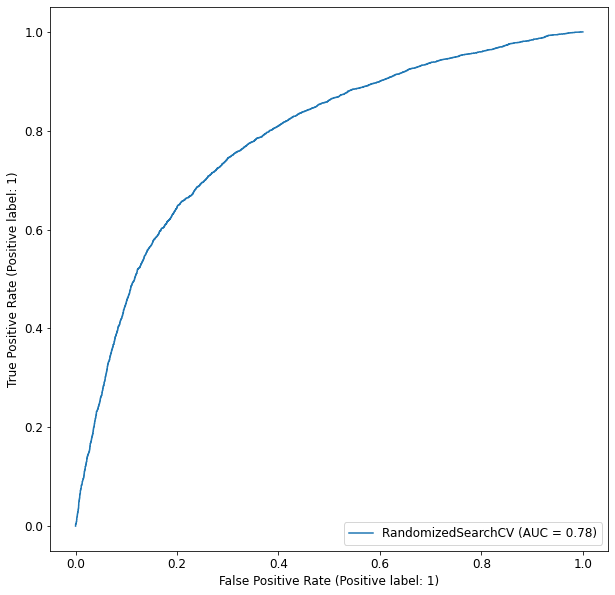

Classifier:  Kmeans
Best hyper parameters : {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2, 'random_state': 1}


c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Classifier Accuracy Precision  Recall   ROC AUC
F1-Score                                                        
0.7298        XGBClassifier   0.7298    0.7308  0.7303  0.793814
0.7218            LinearSVC    0.722     0.724  0.7228      None
0.6942    Nearest Neighbors   0.6942    0.6942  0.6942  0.748907
0.6872        Random Forest   0.6873    0.6872  0.6872  0.742819
0.6624          Naive Bayes   0.6649    0.6728  0.6666  0.741463
0.6161        Decision Tree   0.6162    0.6161  0.6161  0.615129
0.3304               Kmeans   0.3431    0.3295  0.3407      None

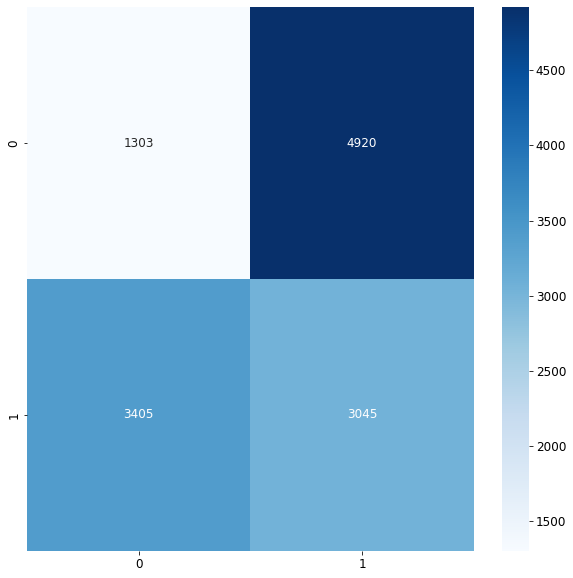

In [ ]:
X_train, X_test, y_train, y_test = tt_split(df_cleaned[["age", "gender", "height", "weight", "BMI", "systolic_bp", "diastolic_bp", "cholesterol_1", "cholesterol_2", "cholesterol_3", "glucose_1", "glucose_2", "glucose_3", "physical_activity", "cardio_disease"]])

result_matrixes["Cleaned dataset without smoke and alcool features"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=5)
display(result_matrixes["Cleaned dataset without smoke and alcool features"])

### Obese/overweight dataset

Classifier:  Decision Tree
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'random'}


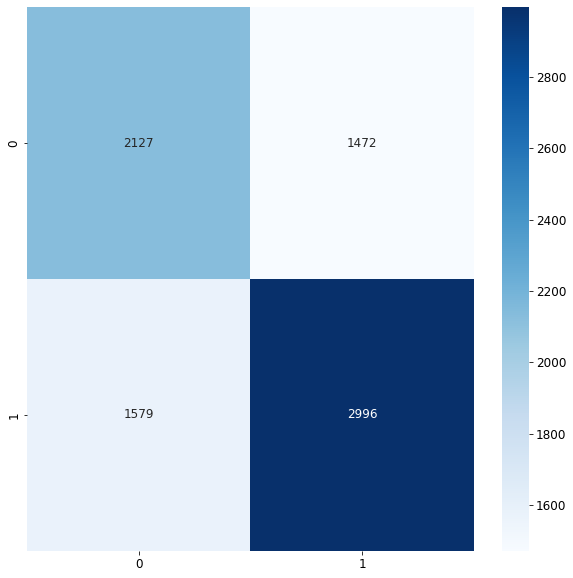

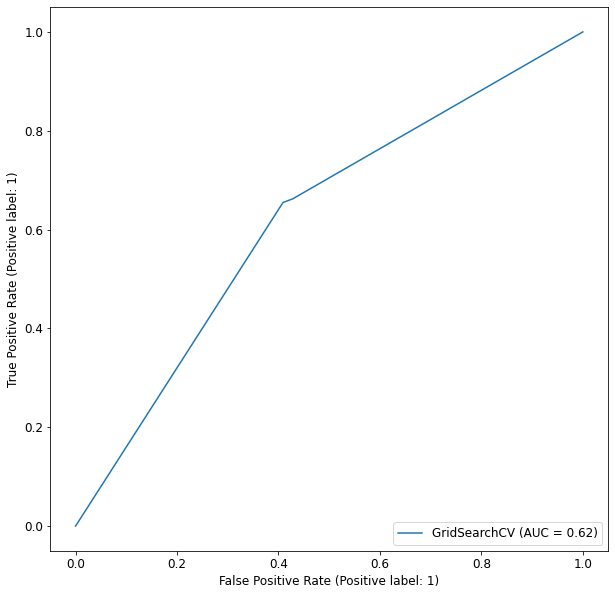

Classifier:  Random Forest
Best hyper parameters : {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


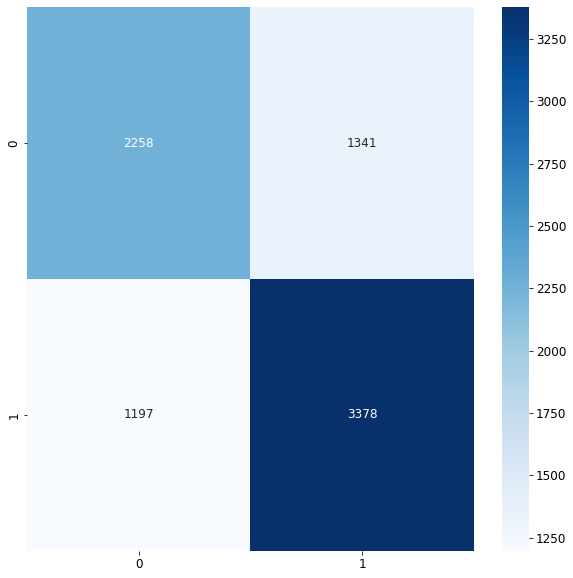

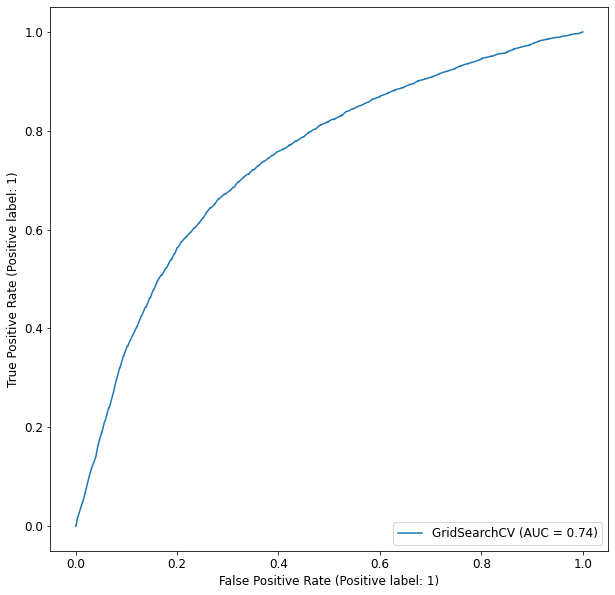

Classifier:  XGBClassifier
Best hyper parameters : {'tree_method': 'exact', 'random_state': 1, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1}


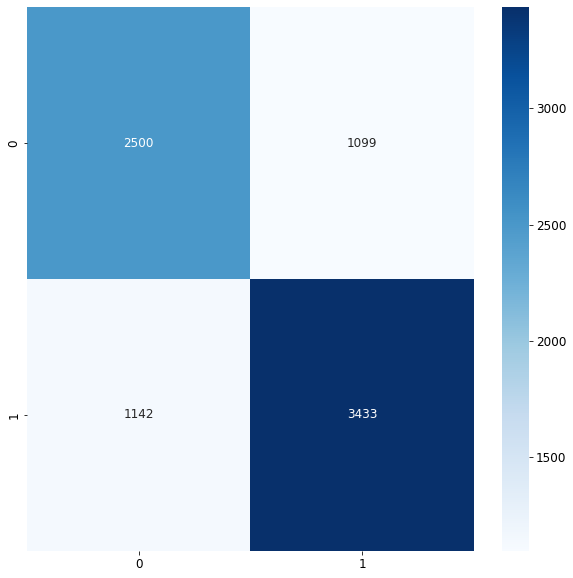

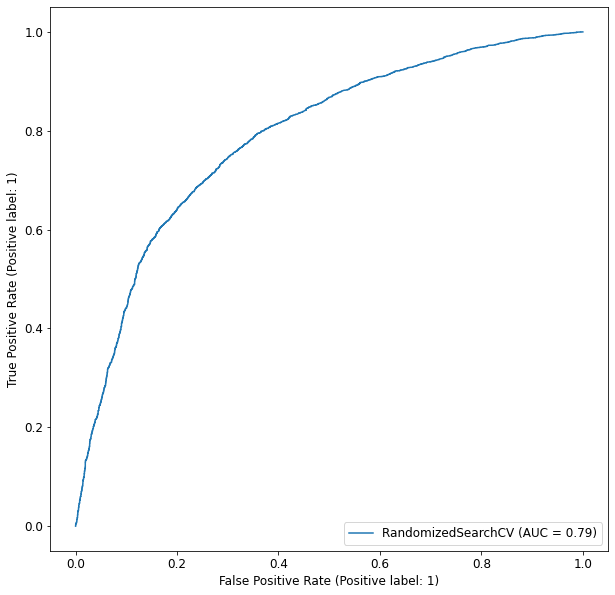

Classifier:  Nearest Neighbors
Best hyper parameters : {'weights': 'distance', 'p': 1, 'n_neighbors': 9, 'n_jobs': -1, 'algorithm': 'ball_tree'}


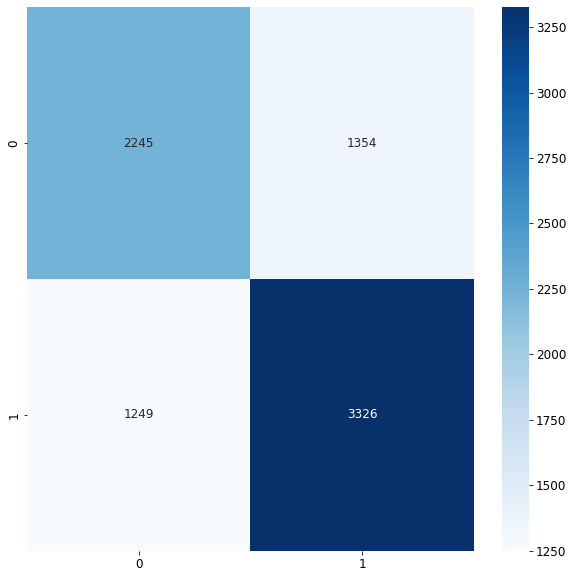

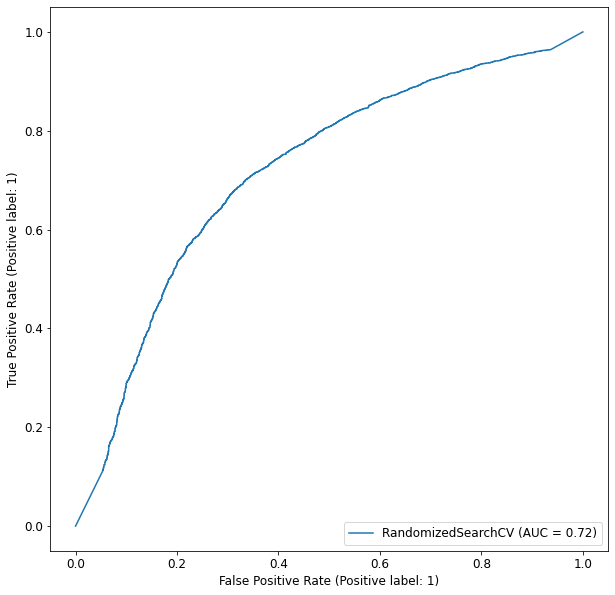

Classifier:  Naive Bayes


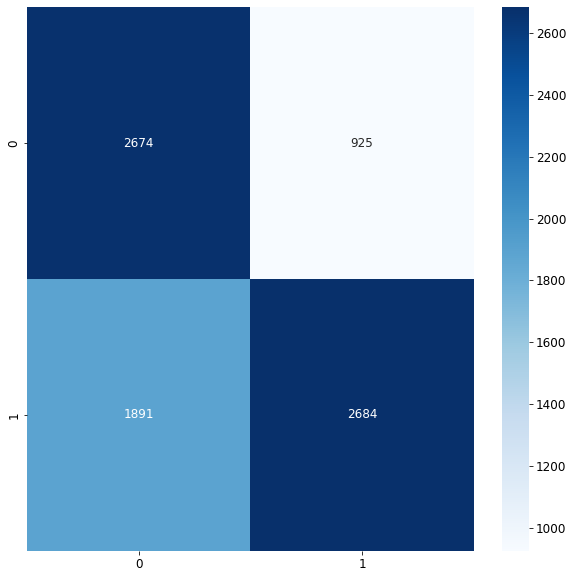

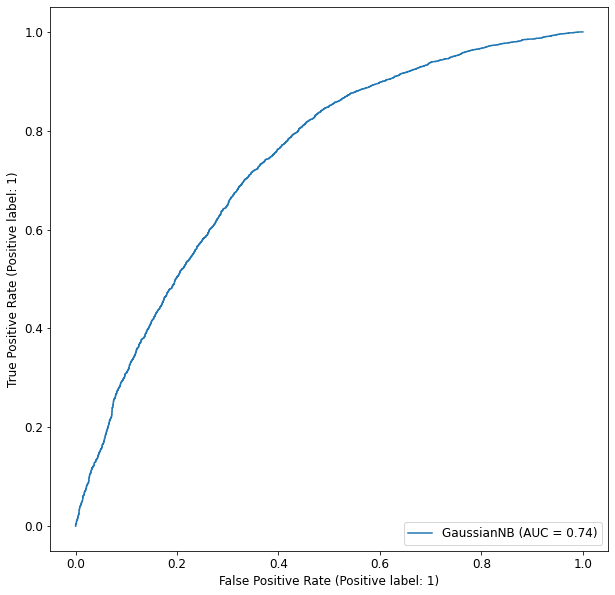

Classifier:  LinearSVC
Best hyper parameters : {'tol': 0.01, 'random_state': 1, 'penalty': 'l1', 'dual': False, 'C': 1}


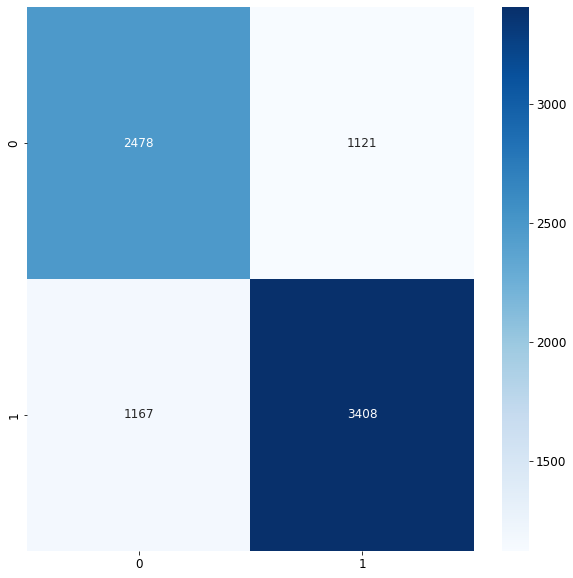

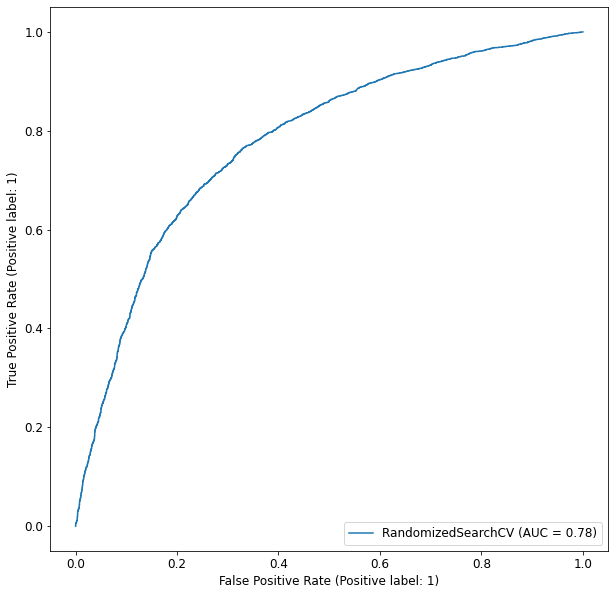

Classifier:  Kmeans
Best hyper parameters : {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2, 'random_state': 1}


c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Classifier Accuracy Precision  Recall   ROC AUC
F1-Score                                                        
0.7222        XGBClassifier   0.7258     0.722  0.7225   0.78737
0.7164            LinearSVC   0.7201    0.7162  0.7167      None
0.6836        Random Forest   0.6895    0.6847  0.6829  0.738937
0.6759    Nearest Neighbors   0.6816    0.6766  0.6754  0.717481
0.6560               Kmeans   0.6568    0.6782  0.6723      None
0.6555          Naive Bayes   0.6555    0.6647  0.6648  0.739343
0.6225        Decision Tree   0.6267    0.6222  0.6229  0.621801

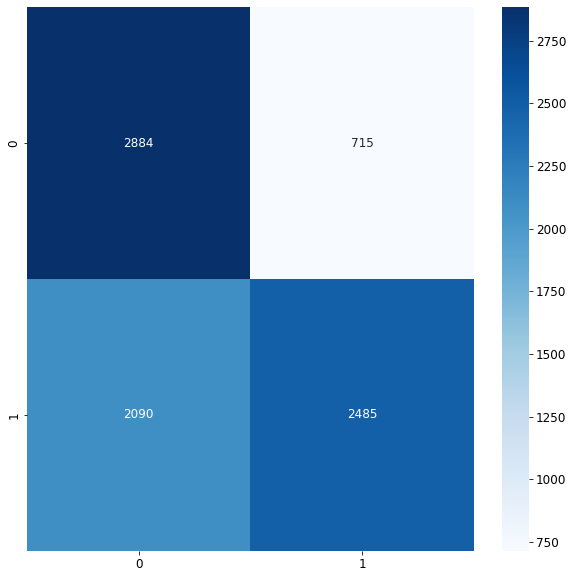

In [ ]:
df_obese = df_cleaned[["age", "gender", "height", "weight", "BMI", "systolic_bp", "diastolic_bp", "cholesterol_1", "cholesterol_2", "cholesterol_3", "glucose_1", "glucose_2", "glucose_3", "physical_activity", "cardio_disease"]]
df_obese = df_obese.loc[BMI >= 25]

X_train, X_test, y_train, y_test = tt_split(df_obese)

result_matrixes["Obese/overweight dataset"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=5)
display(result_matrixes["Obese/overweight dataset"])

### Final results

In [ ]:
for data,result in result_matrixes.items():
    display(data, result)

'Plain dataset'

Classifier Accuracy Precision  Recall   ROC AUC
F1-Score                                                        
0.7271        XGBClassifier   0.7271     0.728  0.7279   0.79618
0.6966        Random Forest   0.6967    0.6966  0.6967   0.75084
0.6544    Nearest Neighbors   0.6544    0.6547  0.6548  0.703156
0.6515            LinearSVC   0.6517    0.6516  0.6517      None
0.6246        Decision Tree   0.6248    0.6246  0.6246  0.623686
0.5722               Kmeans    0.583    0.6008  0.5886      None
0.5462          Naive Bayes   0.5802    0.6347  0.5895  0.682865

'Cleaned dataset'

Classifier Accuracy Precision  Recall   ROC AUC
F1-Score                                                        
0.7315        XGBClassifier   0.7316    0.7323   0.732  0.796952
0.7229            LinearSVC   0.7231    0.7251  0.7239      None
0.7094    Nearest Neighbors   0.7094    0.7094  0.7095   0.76174
0.6844        Random Forest   0.6845    0.6844  0.6845  0.744881
0.6634          Naive Bayes   0.6659    0.6739  0.6677  0.741708
0.6174        Decision Tree   0.6176    0.6175  0.6174  0.617216
0.3306               Kmeans    0.343    0.3297  0.3407      None

'Cleaned dataset without smoke and alcool features'

Classifier Accuracy Precision  Recall   ROC AUC
F1-Score                                                        
0.7298        XGBClassifier   0.7298    0.7308  0.7303  0.793814
0.7218            LinearSVC    0.722     0.724  0.7228      None
0.6942    Nearest Neighbors   0.6942    0.6942  0.6942  0.748907
0.6872        Random Forest   0.6873    0.6872  0.6872  0.742819
0.6624          Naive Bayes   0.6649    0.6728  0.6666  0.741463
0.6161        Decision Tree   0.6162    0.6161  0.6161  0.615129
0.3304               Kmeans   0.3431    0.3295  0.3407      None

'Obese/overweight dataset'

Classifier Accuracy Precision  Recall   ROC AUC
F1-Score                                                        
0.7222        XGBClassifier   0.7258     0.722  0.7225   0.78737
0.7164            LinearSVC   0.7201    0.7162  0.7167      None
0.6836        Random Forest   0.6895    0.6847  0.6829  0.738937
0.6759    Nearest Neighbors   0.6816    0.6766  0.6754  0.717481
0.6560               Kmeans   0.6568    0.6782  0.6723      None
0.6555          Naive Bayes   0.6555    0.6647  0.6648  0.739343
0.6225        Decision Tree   0.6267    0.6222  0.6229  0.621801